####################################################################################

AEDA PROJEKT

Rozdíly mezi skupinami (PD, RBD, HC):

        o H0: Neexistují významné rozdíly v parametrech očních pohybů mezi skupinami
PD, RBD a HC.

        o H1: Existují významné rozdíly v parametrech očních pohybů mezi skupinami
PD, RBD a HC.

####################################################################################

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA
import os
import seaborn as sns 

##############################
#   ZÁKLADNÍ KLINICKÁ DATA   #
##############################


==== Analýza pre parameter: Věk ====
Cohenovo d: -0.3036
Shapiro-Wilk test normálnosti:
  PD: p=4.2039e-01
  RBD: p=7.7835e-03
Levene test homogenity variancií: Stat=1.3506, p=2.4942e-01
Mann-Whitney U test: Stat=428.5000, p=2.1329e-01
Graf uložený ako Věk_graf.png


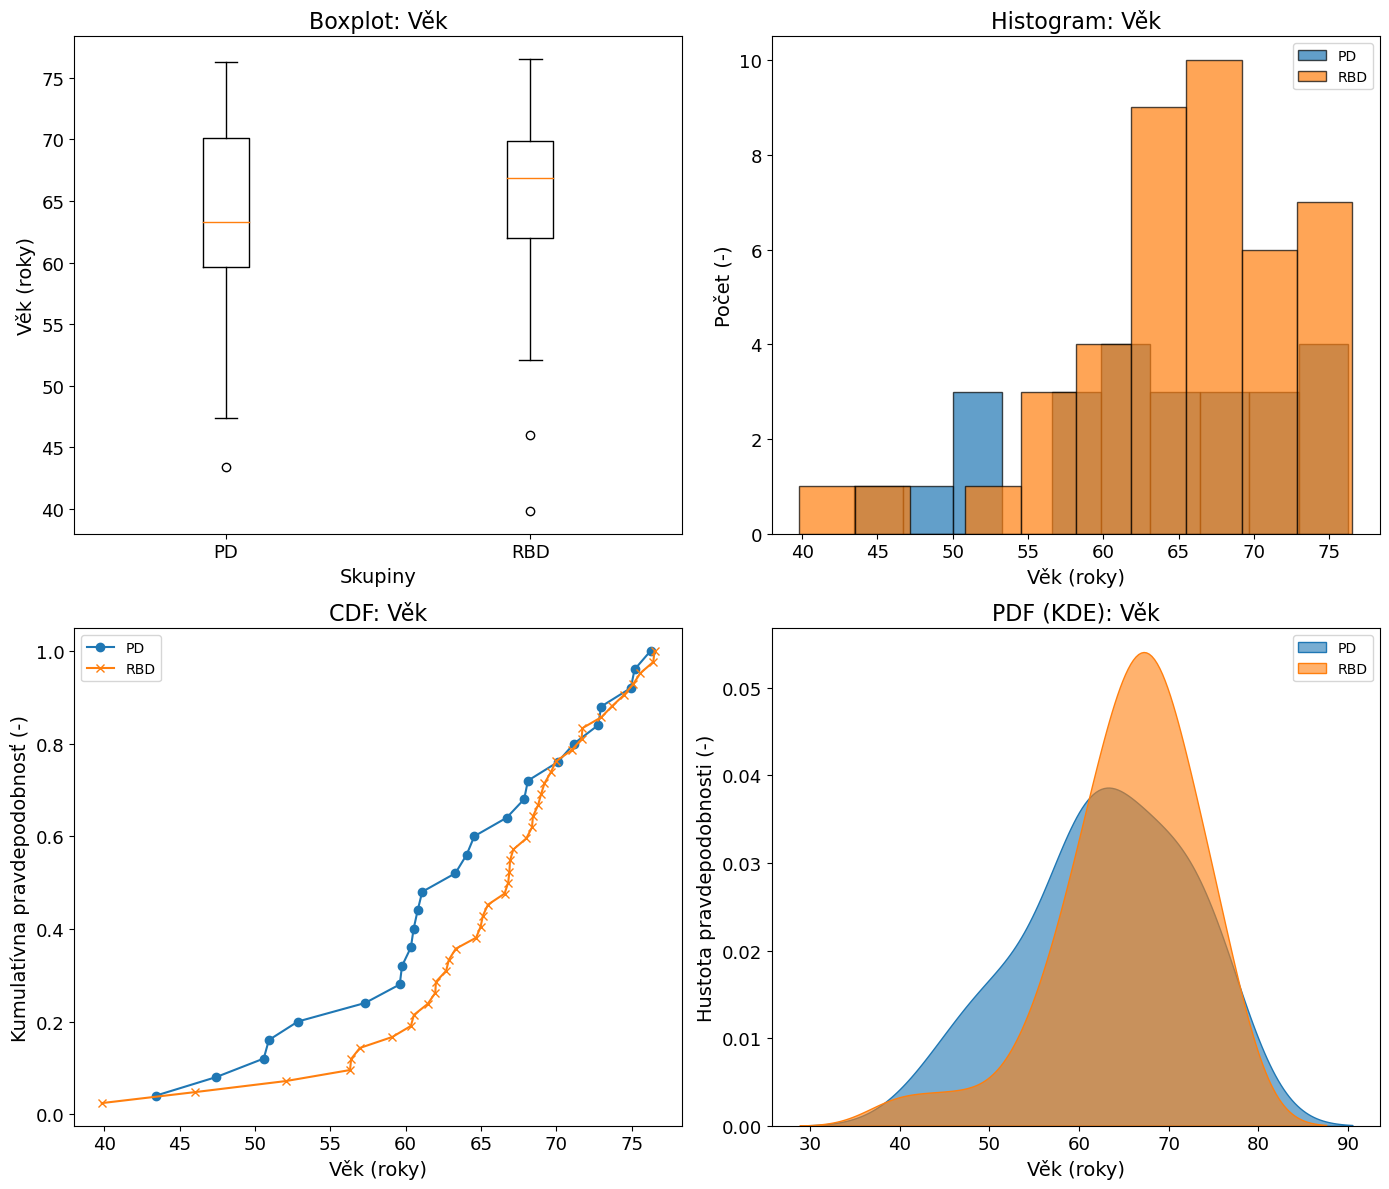


==== Analýza pre parameter: MoCA ====
Cohenovo d: -0.1526
Shapiro-Wilk test normálnosti:
  PD: p=6.7924e-01
  RBD: p=6.0636e-01
Levene test homogenity variancií: Stat=0.6609, p=4.1922e-01
T-test: Stat=-0.6041, p=5.4786e-01
Graf uložený ako MoCA_graf.png


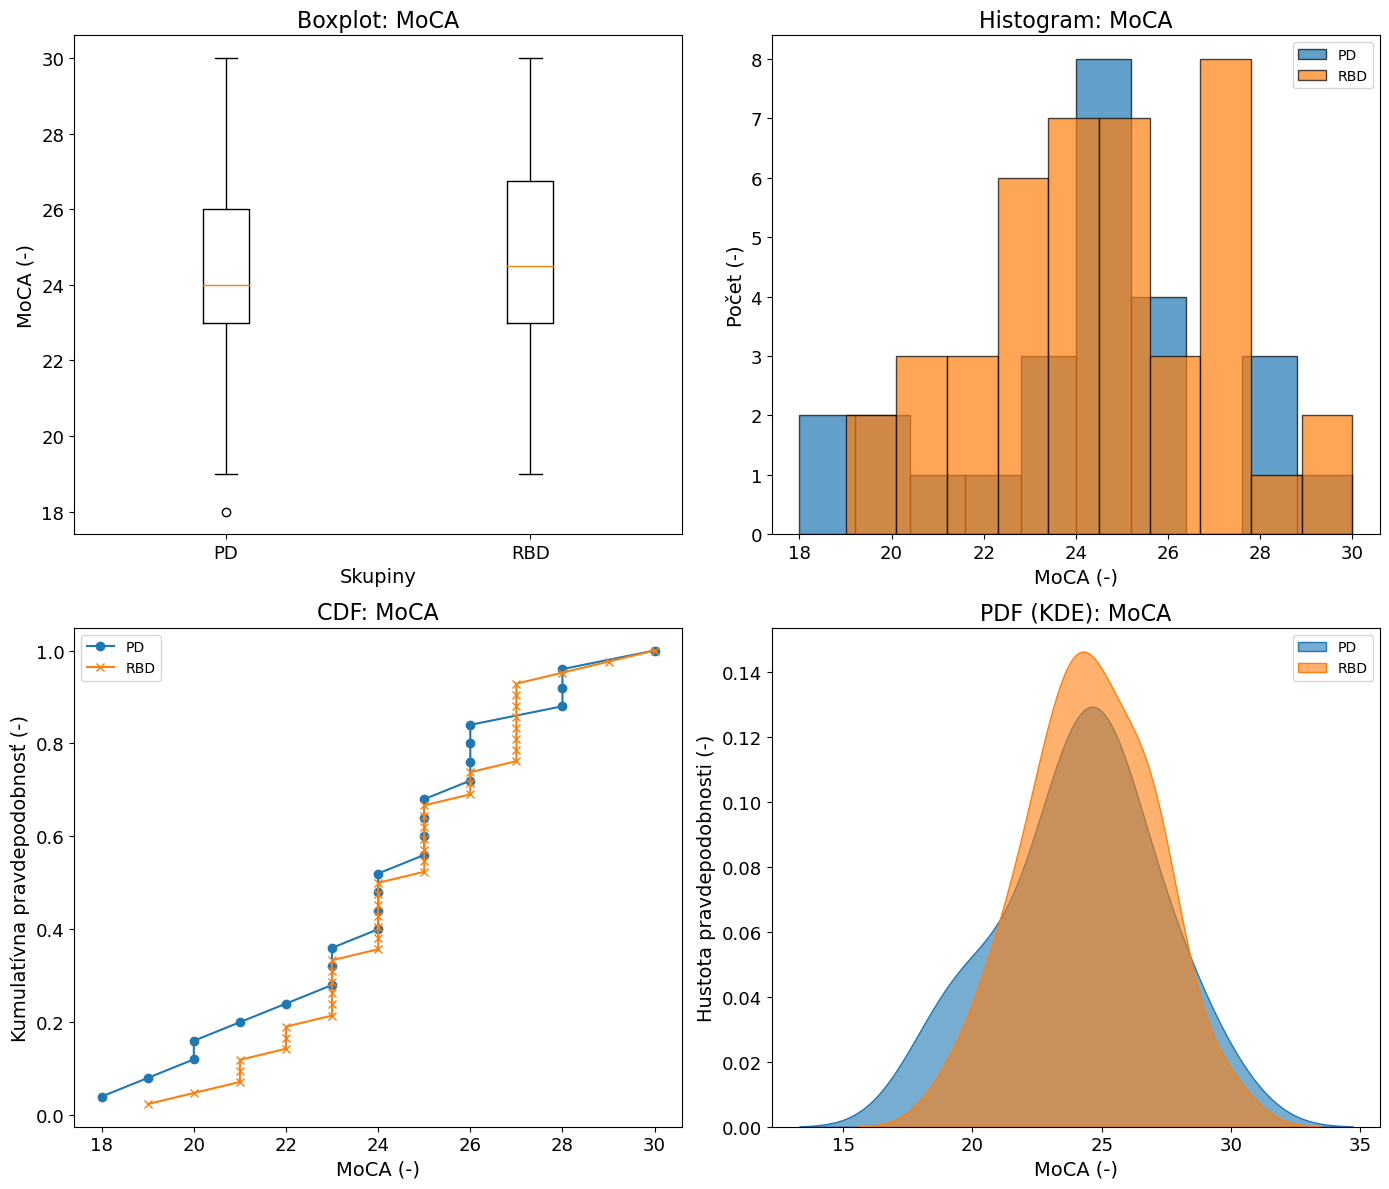


==== Analýza pre parameter: UPDRS III ====
Cohenovo d: 1.6177
Shapiro-Wilk test normálnosti:
  PD: p=1.9369e-01
  RBD: p=1.0415e-04
Levene test homogenity variancií: Stat=36.0912, p=9.3966e-08
Mann-Whitney U test: Stat=880.5000, p=3.8671e-06
Graf uložený ako UPDRS III_graf.png


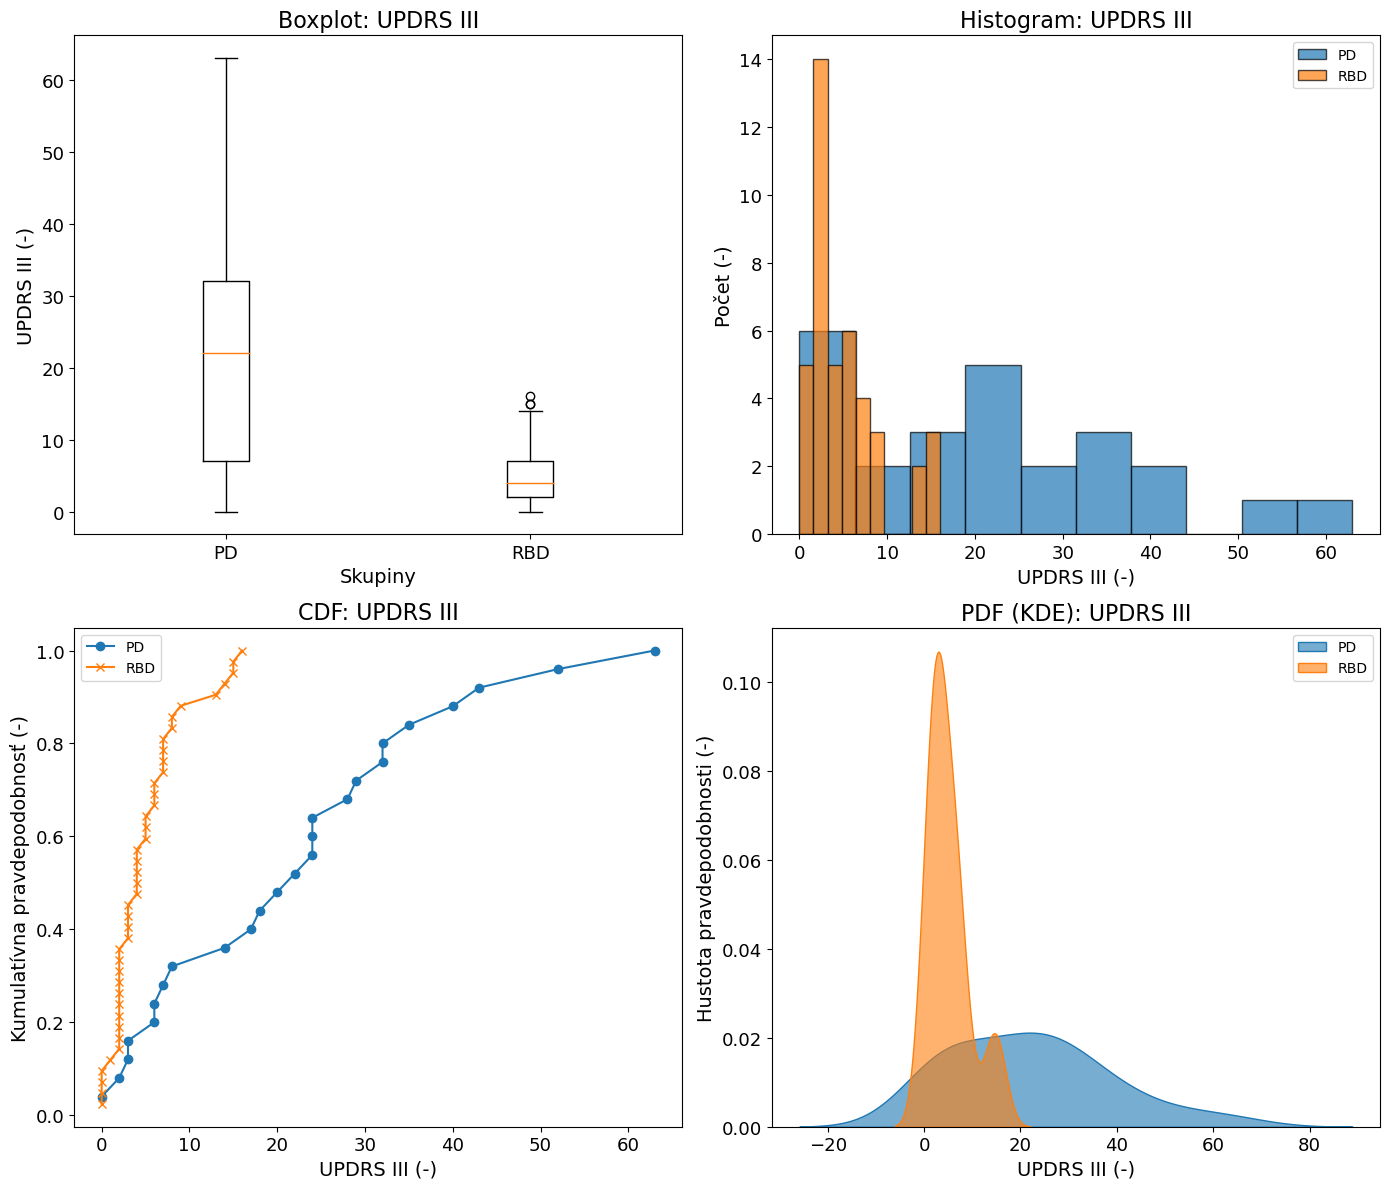

In [3]:
# 1. Načítanie dát
data = pd.read_csv("data.csv") 

# Výber relevantných riadkov (5-77) a stĺpcov (2-4)
data = data.iloc[4:77, 1:4]  # Riadky 5–77, stĺpce 2–4
data.columns = ['Věk', 'MoCA', 'UPDRS III']  # Pre čitateľnosť pridáme názvy stĺpcov

# Kontrola a konverzia na číselné hodnoty
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Konverzia na čísla, NaN pre neplatné hodnoty

# Odstránenie riadkov s NaN hodnotami
data = data.dropna()

# Rozdelenie na skupiny podľa riadkov
group_PD = data.iloc[:25]  # Riadky 5–29 (indexy 0–24) sú PD
group_RBD = data.iloc[25:]  # Riadky 30–77 (indexy 25–72) sú RBD

# Získanie aktuálneho adresára
current_directory = os.getcwd()

# Funkcia na vykonanie testov a vizualizácie
def analyze_param(param_name):
    print(f"\n==== Analýza pre parameter: {param_name} ====")
    
    values_PD = group_PD[param_name]
    values_RBD = group_RBD[param_name]
    
    # Výpočet Cohenovho d
    mean_PD, mean_RBD = np.mean(values_PD), np.mean(values_RBD)
    std_PD, std_RBD = np.std(values_PD, ddof=1), np.std(values_RBD, ddof=1)
    pooled_std = np.sqrt(((std_PD ** 2) * (len(values_PD) - 1) + (std_RBD ** 2) * (len(values_RBD) - 1)) / 
                         (len(values_PD) + len(values_RBD) - 2))
    cohens_d = (mean_PD - mean_RBD) / pooled_std
    print(f"Cohenovo d: {cohens_d:.4f}")
    
    # Test normálnosti
    p_PD = shapiro(values_PD)[1]
    p_RBD = shapiro(values_RBD)[1]
    print(f"Shapiro-Wilk test normálnosti:")
    print(f"  PD: p={p_PD:.4e}")
    print(f"  RBD: p={p_RBD:.4e}")
    
    # Test homogenity variancií
    stat_homogeneity, p_homogeneity = levene(values_PD, values_RBD)
    print(f"Levene test homogenity variancií: Stat={stat_homogeneity:.4f}, p={p_homogeneity:.4e}")
    
    # Výber testu
    if p_PD > 0.05 and p_RBD > 0.05:
        # Parametrický test (t-test)
        t_stat, t_p = ttest_ind(values_PD, values_RBD, equal_var=(p_homogeneity > 0.05))
        print(f"T-test: Stat={t_stat:.4f}, p={t_p:.4e}")
    else:
        # Neparametrický test (Mann-Whitney U test)
        mw_stat, mw_p = mannwhitneyu(values_PD, values_RBD, alternative='two-sided')
        print(f"Mann-Whitney U test: Stat={mw_stat:.4f}, p={mw_p:.4e}")
    
    units = {'Věk': 'roky', 
             'MoCA': '-',
             'UPDRS III': '-'}
    
    # Vizualizácia
    plt.figure(figsize=(14, 12))

    # Boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot([values_PD, values_RBD], labels=['PD', 'RBD'])
    plt.title(f"Boxplot: {param_name}", fontsize=16)
    plt.xlabel("Skupiny", fontsize=14) 
    plt.ylabel(f"{param_name} ({units[param_name]})", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Histogram
    plt.subplot(2, 2, 2)
    plt.hist(values_PD, bins=10, alpha=0.7, label='PD', edgecolor='k')
    plt.hist(values_RBD, bins=10, alpha=0.7, label='RBD', edgecolor='k')
    plt.title(f"Histogram: {param_name}", fontsize=16)
    plt.xlabel(f"{param_name} ({units[param_name]})", fontsize=14) 
    plt.ylabel("Počet (-)", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend()
    
    # CDF graf
    plt.subplot(2, 2, 3)
    sorted_PD = np.sort(values_PD)
    sorted_RBD = np.sort(values_RBD)
    cdf_PD = np.arange(1, len(sorted_PD) + 1) / len(sorted_PD)
    cdf_RBD = np.arange(1, len(sorted_RBD) + 1) / len(sorted_RBD)
    plt.plot(sorted_PD, cdf_PD, label='PD', marker='o')
    plt.plot(sorted_RBD, cdf_RBD, label='RBD', marker='x')
    plt.title(f"CDF: {param_name}", fontsize=16)
    plt.xlabel(f"{param_name} ({units[param_name]})", fontsize=14)
    plt.ylabel("Kumulatívna pravdepodobnosť (-)", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend()
    
    # PDF graf (KDE)
    plt.subplot(2, 2, 4)
    sns.kdeplot(values_PD, label='PD', fill=True, alpha=0.6)
    sns.kdeplot(values_RBD, label='RBD', fill=True, alpha=0.6)
    plt.title(f"PDF (KDE): {param_name}", fontsize=16)
    plt.xlabel(f"{param_name} ({units[param_name]})", fontsize=14)
    plt.ylabel("Hustota pravdepodobnosti (-)", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend()
    
    plt.tight_layout()
    file_name = f"{param_name}_graf.png"
    plt.savefig(os.path.join(current_directory, file_name))
    print(f"Graf uložený ako {file_name}")
    plt.show()

# Analyzujem každý parameter
for param in ['Věk', 'MoCA', 'UPDRS III']:
    analyze_param(param)



###########################################################
# KONTROLA NORMALITY A HOMOGENITY, ANOVA/ KRUSKAL-WALLIS TEST - ANTISAKÁDY #
###########################################################

In [4]:
# Funkcia na načítanie a predspracovanie údajov
def load_and_preprocess_data(file_path, rows, cols, column_names):
    data = pd.read_csv(file_path)
    data = data.iloc[rows, cols]
    data.columns = column_names
    
    for col in column_names[1:]:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    data = data.dropna()
    data.loc[4:28, 'Skupina'] = 'PD'
    data.loc[29:76, 'Skupina'] = 'RBD'
    data.loc[77:101, 'Skupina'] = 'HC'
    
    return data

# Funkcia na výpočet Cohenovho d
def compute_cohen_d(group1, group2):
    diff_mean = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)
    return diff_mean / pooled_std


# Funkcia na vytvorenie vizualizácií
def create_visualizations(data, column, units, save_path, titles, dataset_label):
    groups = {group: data[data['Skupina'] == group][column].dropna() for group in ['PD', 'RBD', 'HC']}
    plt.figure(figsize=(16, 12))
    
    # Boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot(groups.values(), labels=groups.keys())
    plt.title(titles.get('boxplot', f"Boxplot: {column}"), fontsize=16)
    plt.xlabel("Skupiny", fontsize=14)
    plt.ylabel(f"{column} ({units})", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Histogram
    plt.subplot(2, 2, 2)
    for group, values in groups.items():
        plt.hist(values, bins=10, alpha=0.7, label=group, edgecolor='k')
    plt.title(titles.get('histogram', f"Histogram: {column}"), fontsize=16)
    plt.xlabel(f"{column} ({units})", fontsize=14)
    plt.ylabel("Počet (-)", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend()
    
    # CDF graph
    plt.subplot(2, 2, 3)
    for group, values in groups.items():
        sorted_values = np.sort(values)
        cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        plt.plot(sorted_values, cdf, label=group, marker='o', linestyle='-')
    plt.title(titles.get('cdf', f"CDF: {column}"), fontsize=16)
    plt.xlabel(f"{column} ({units})", fontsize=14)
    plt.ylabel("Kumulatívna pravdepodobnosť (-)", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend()
    
    # PDF graph
    plt.subplot(2, 2, 4)
    for group, values in groups.items():
        sns.kdeplot(values, label=group, fill=True, alpha=0.6)
    plt.title(titles.get('pdf', f"PDF (KDE): {column}"), fontsize=16)
    plt.xlabel(f"{column} ({units})", fontsize=14)
    plt.ylabel("Hustota pravdepodobnosti (-)", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend()
    
    plt.tight_layout()
    # Save with dataset label
    plt.savefig(os.path.join(save_path, f"{dataset_label}_{column}_visualization.png"))
    plt.show()



# Funkcia na vykonanie štatistických testov
def perform_statistical_tests(data, column):
    print(f"\n==== Testy pre parameter: {column} ====")
    groups = {group: data[data['Skupina'] == group][column] for group in ['PD', 'RBD', 'HC']}
    
    # Test normálnosti
    print("Shapiro-Wilk test normálnosti:")
    for group, values in groups.items():
        p_value = shapiro(values)[1]
        print(f"  {group}: p={p_value:.4e}")
    
    # Test homogenity variancií
    stat_homogeneity, p_homogeneity = levene(*groups.values())
    print(f"Levene test homogenity variancií: Stat={stat_homogeneity:.4f}, p={p_homogeneity:.4e}")
    
    if all(shapiro(values)[1] > 0.05 for values in groups.values()) and p_homogeneity > 0.05:
        # Parametrický test (ANOVA)
        stat, p_value = f_oneway(*groups.values())
        print(f"ANOVA: Stat={stat:.4f}, p={p_value:.4e}")
        if p_value < 0.05:
            tukey = pairwise_tukeyhsd(endog=data[column], groups=data['Skupina'])
            print("\nPost-hoc test (Tukey HSD):")
            print(tukey)

            # Cohenovo d pre štatisticky významné rozdiely
            for comparison in tukey._results_table.data[1:]:
                group1, group2, p_val = comparison[0], comparison[1], comparison[4]
                if p_val < 0.05:  # Štatisticky významný rozdiel
                    d = compute_cohen_d(groups[group1], groups[group2])
                    print(f"Cohenovo d ({group1} vs {group2}): {d:.4f}")

    else:
        # Neparametrický test (Kruskal-Wallis)
        stat, p_value = kruskal(*groups.values())
        print(f"Kruskal-Wallis: Stat={stat:.4f}, p={p_value:.4e}")
        if p_value < 0.05:
            dunn = posthoc_dunn(data, val_col=column, group_col='Skupina', p_adjust='bonferroni')
            print("\nPost-hoc test (Dunnov test):")
            print(dunn)

            # Cohenovo d pre štatisticky významné rozdiely
            for group1 in groups:
                for group2 in groups:
                    if group1 != group2 and dunn.loc[group1, group2] < 0.05:  # Štatisticky významný rozdiel
                        d = compute_cohen_d(groups[group1], groups[group2])
                        print(f"Cohenovo d ({group1} vs {group2}): {d:.4f}")

##############################
#   HORIZONTÁLNÍ a VERTIKÁLNÍ ANTISAKÁDY  #
##############################


==== Horizontální antisakády ====


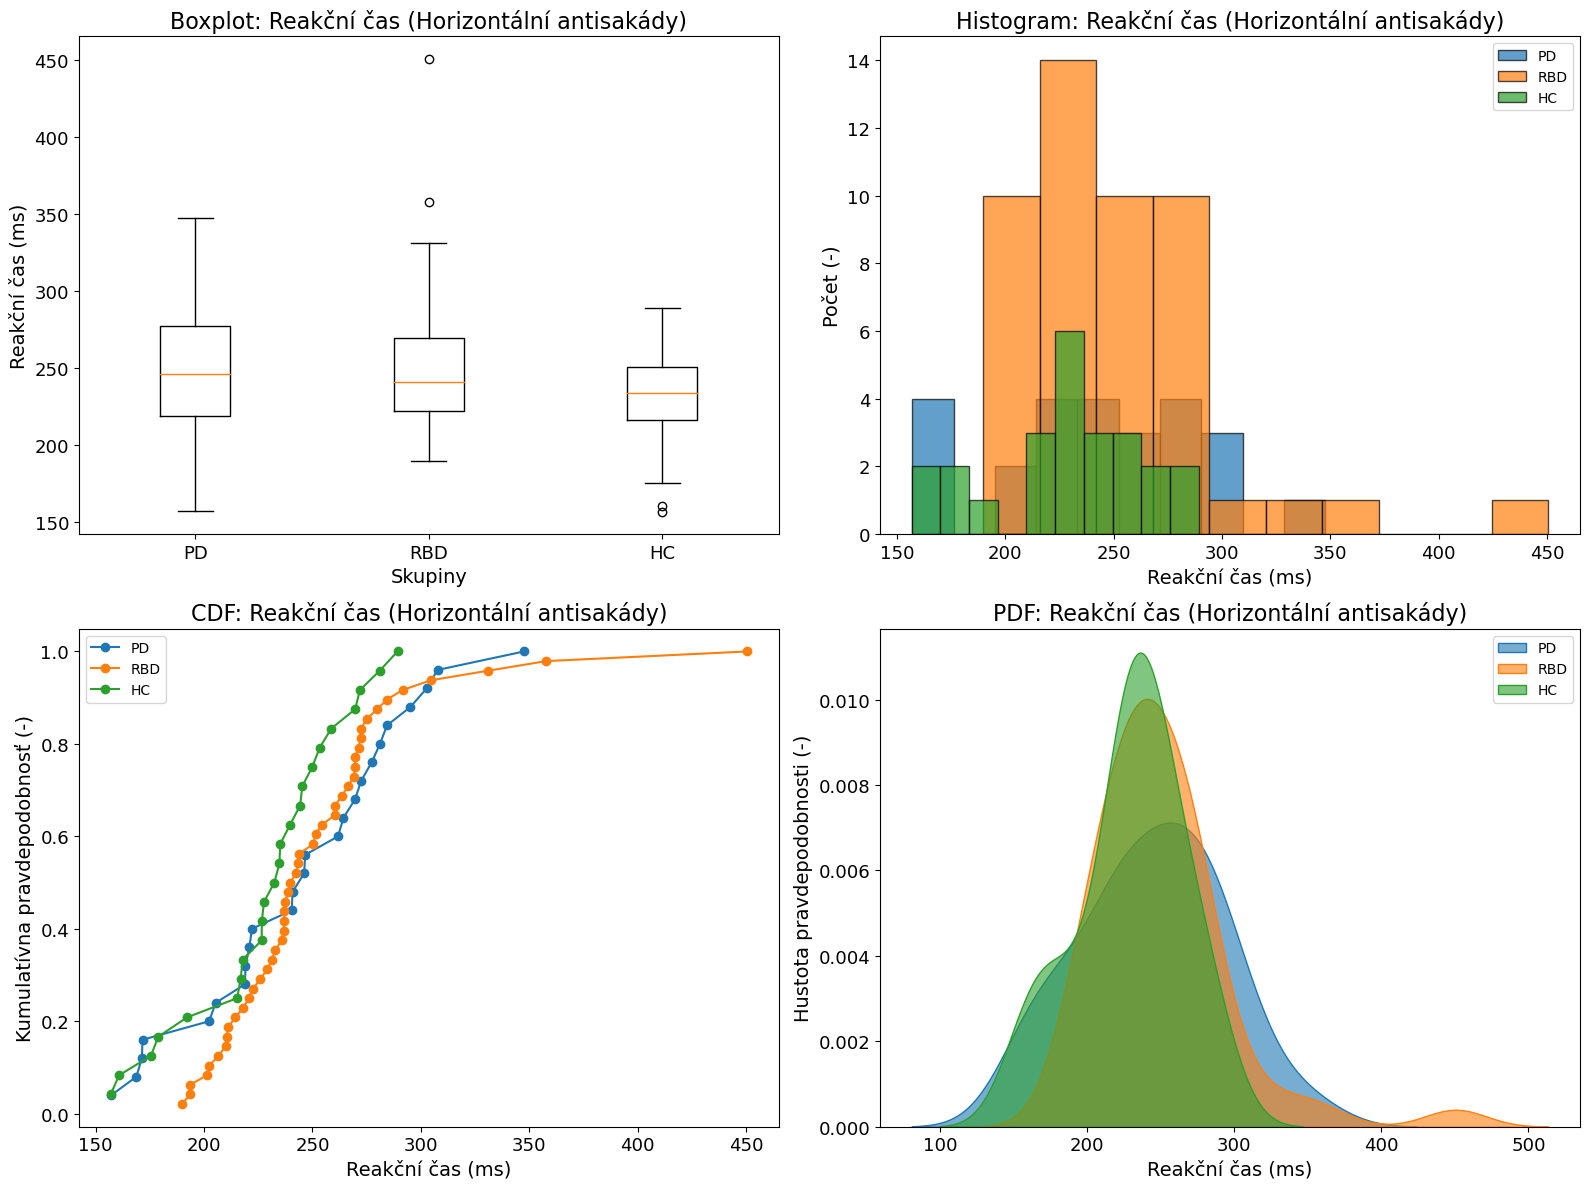


==== Testy pre parameter: Reakční čas ====
Shapiro-Wilk test normálnosti:
  PD: p=7.9719e-01
  RBD: p=9.8311e-06
  HC: p=3.4983e-01
Levene test homogenity variancií: Stat=1.0264, p=3.6228e-01
Kruskal-Wallis: Stat=2.5519, p=2.7916e-01


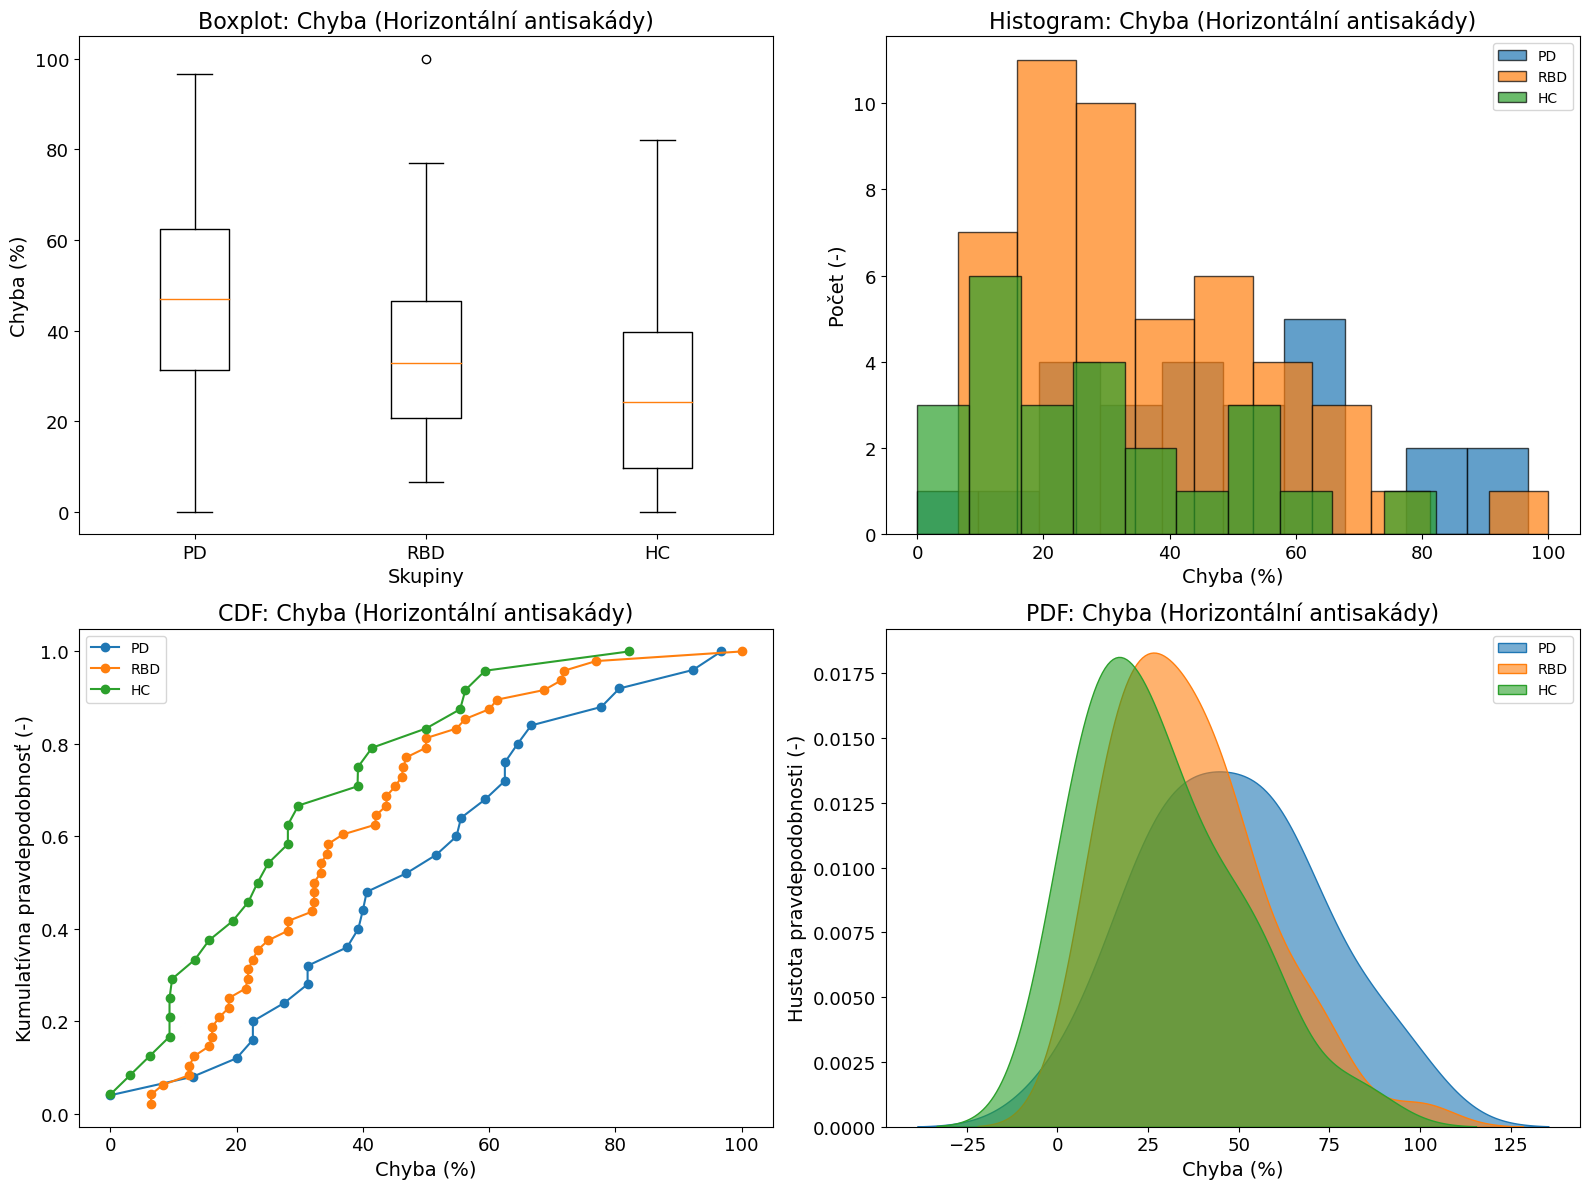


==== Testy pre parameter: Chyba ====
Shapiro-Wilk test normálnosti:
  PD: p=9.5786e-01
  RBD: p=2.5662e-02
  HC: p=1.0359e-01
Levene test homogenity variancií: Stat=0.7831, p=4.5996e-01
Kruskal-Wallis: Stat=9.4284, p=8.9669e-03

Post-hoc test (Dunnov test):
           HC        PD       RBD
HC   1.000000  0.006692  0.360096
PD   0.006692  1.000000  0.147567
RBD  0.360096  0.147567  1.000000
Cohenovo d (PD vs HC): 0.8659
Cohenovo d (HC vs PD): -0.8659

==== Vertikální antisakády ====


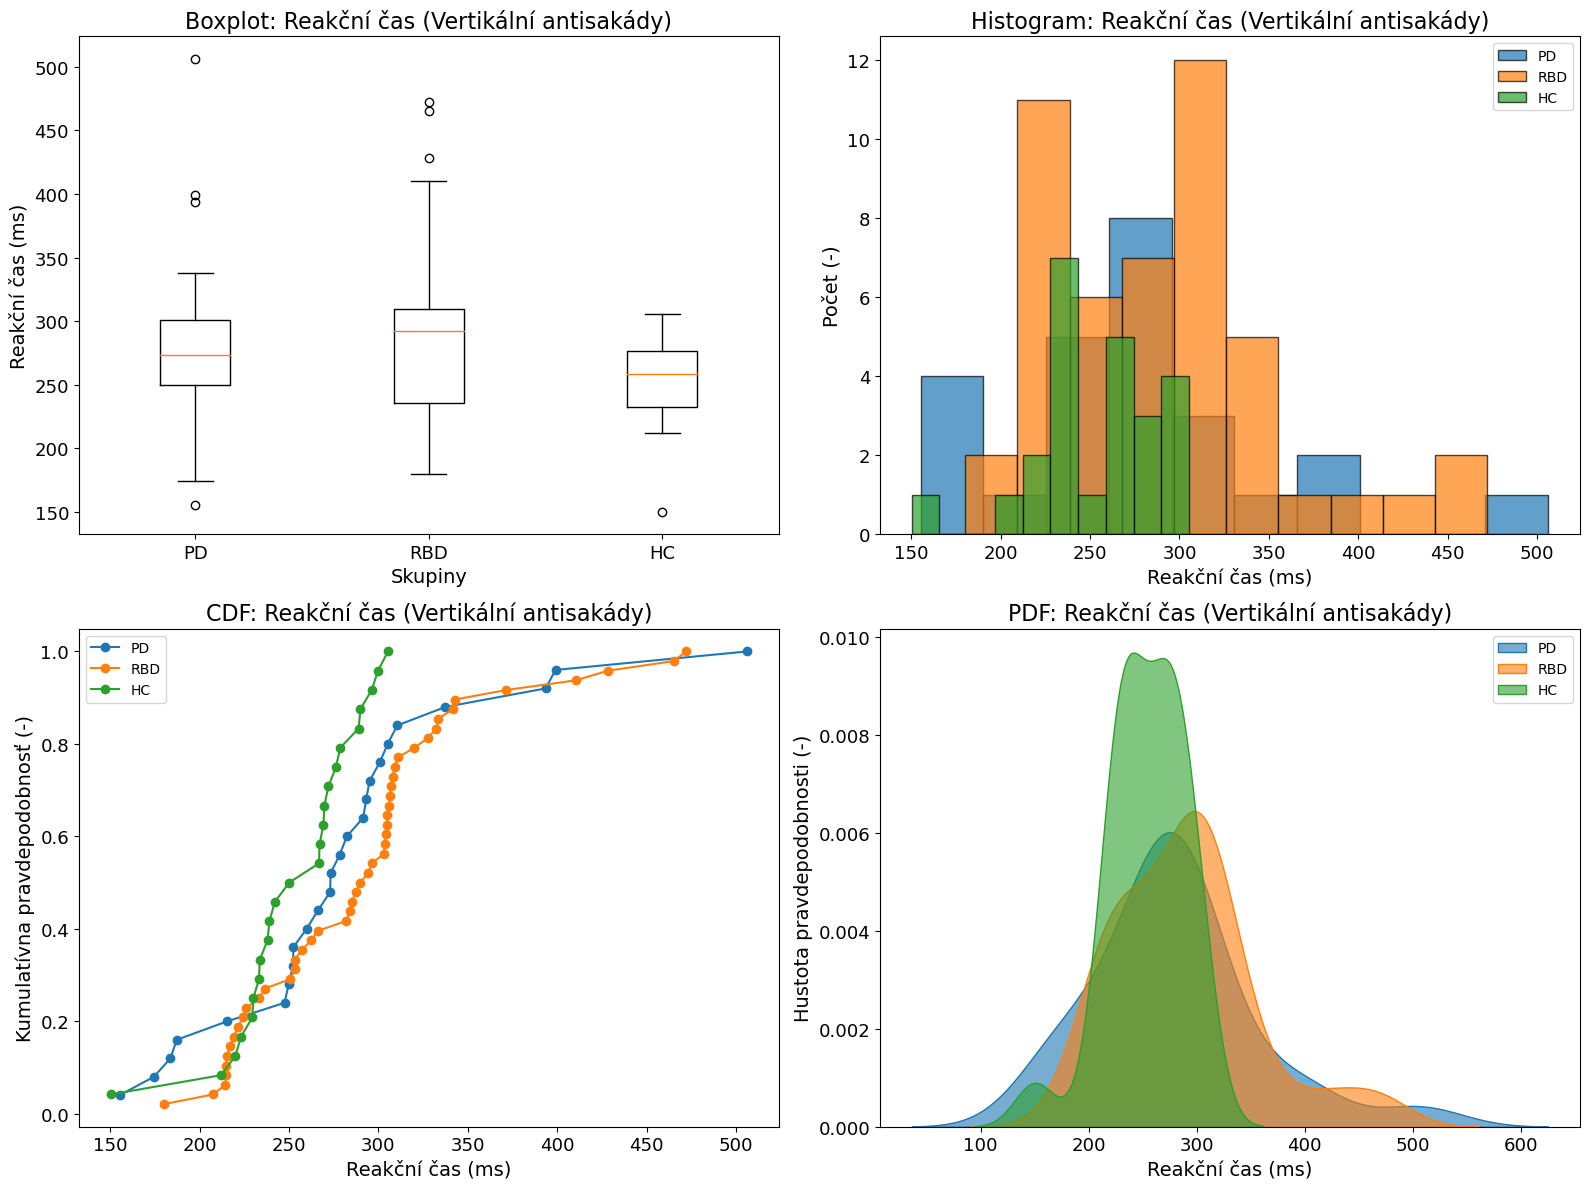


==== Testy pre parameter: Reakční čas ====
Shapiro-Wilk test normálnosti:
  PD: p=3.8097e-02
  RBD: p=3.1173e-03
  HC: p=9.6355e-02
Levene test homogenity variancií: Stat=2.2184, p=1.1445e-01
Kruskal-Wallis: Stat=6.0125, p=4.9476e-02

Post-hoc test (Dunnov test):
           HC        PD       RBD
HC   1.000000  0.493975  0.042673
PD   0.493975  1.000000  1.000000
RBD  0.042673  1.000000  1.000000
Cohenovo d (RBD vs HC): 0.6954
Cohenovo d (HC vs RBD): -0.6954


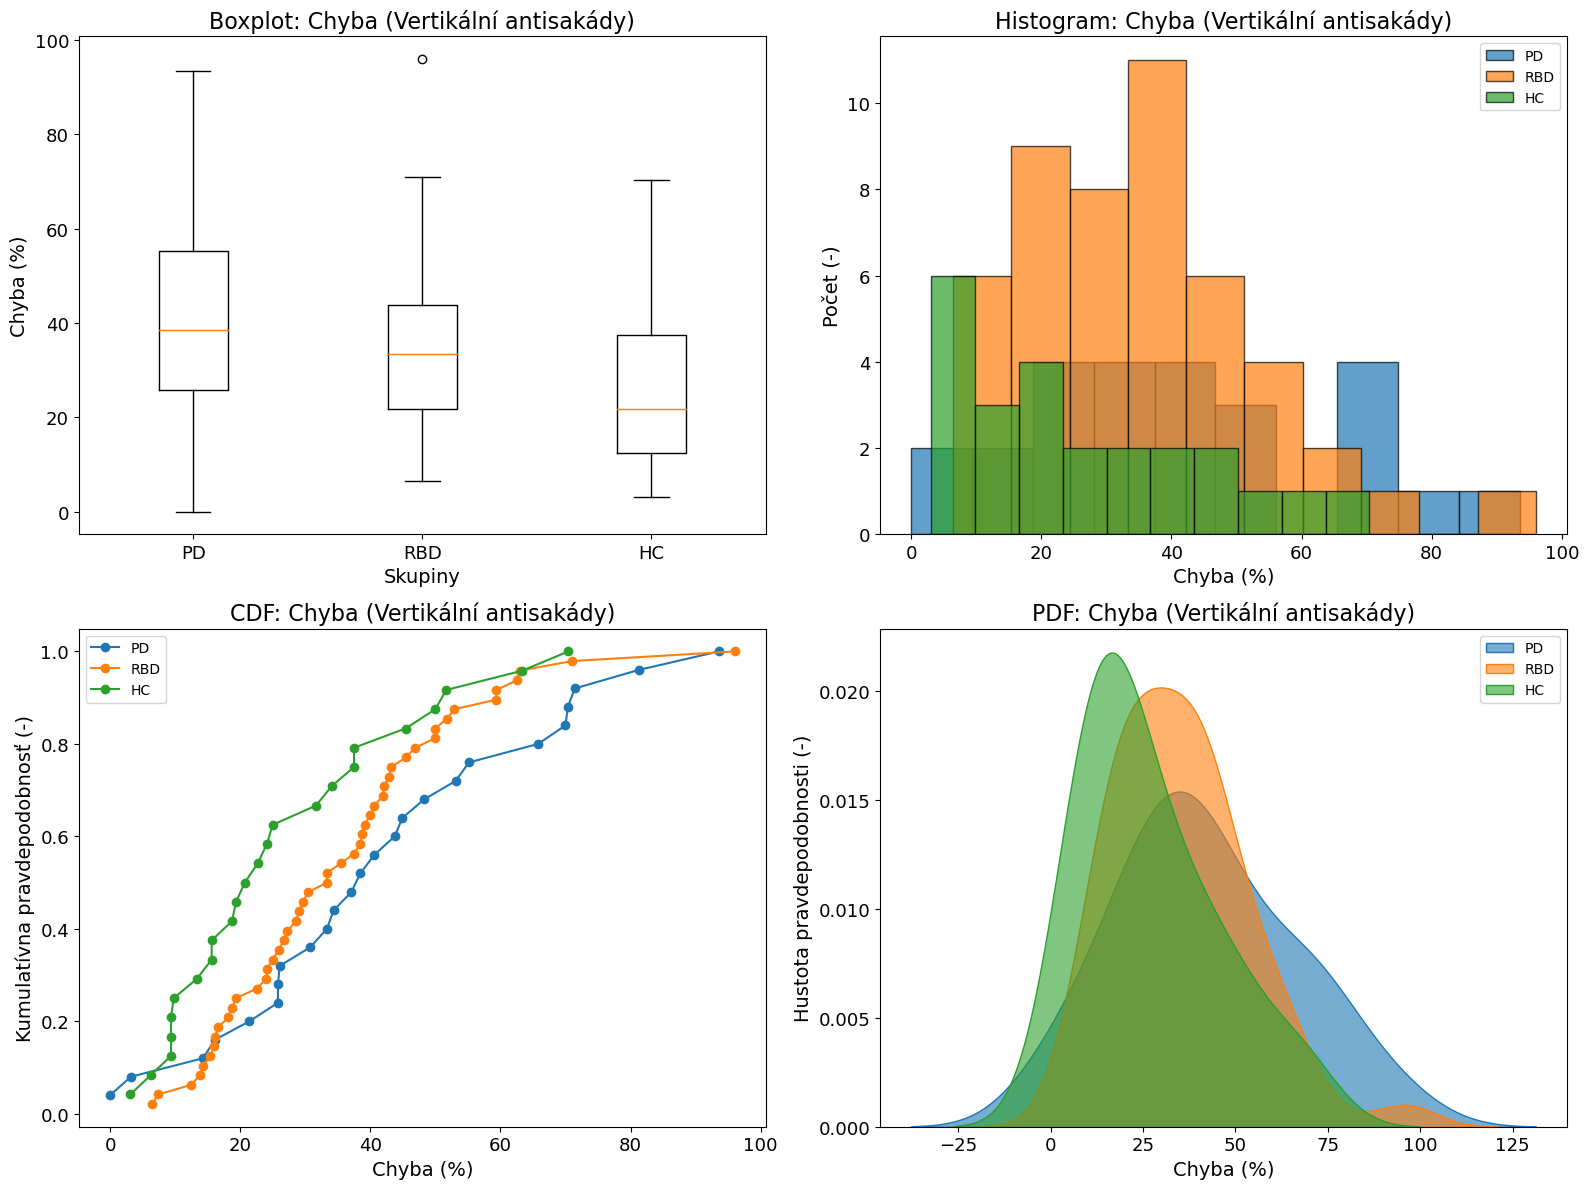


==== Testy pre parameter: Chyba ====
Shapiro-Wilk test normálnosti:
  PD: p=8.3788e-01
  RBD: p=4.0123e-02
  HC: p=4.7044e-02
Levene test homogenity variancií: Stat=1.2508, p=2.9100e-01
Kruskal-Wallis: Stat=7.0197, p=2.9902e-02

Post-hoc test (Dunnov test):
           HC        PD       RBD
HC   1.000000  0.027457  0.169601
PD   0.027457  1.000000  0.831170
RBD  0.169601  0.831170  1.000000
Cohenovo d (PD vs HC): 0.6999
Cohenovo d (HC vs PD): -0.6999


In [5]:
file_path = "data.csv"
rows = slice(4, 102)
cols_list_1 = [0, 4, 5]
cols_list_2 = [0, 6, 7]
column_names = ['Skupina', 'Reakční čas', 'Chyba']

data1 = load_and_preprocess_data(file_path, rows, cols_list_1, column_names)
data2 = load_and_preprocess_data(file_path, rows, cols_list_2, column_names)

for data, dataset_label in zip([data1, data2], ['Horizontální antisakády', 'Vertikální antisakády']):
    print(f"\n==== {dataset_label} ====")
    for col in ['Reakční čas', 'Chyba']:
        units = 'ms' if col == 'Reakční čas' else '%'
        titles = {
            'boxplot': f"Boxplot: {col} ({dataset_label})",
            'histogram': f"Histogram: {col} ({dataset_label})",
            'cdf': f"CDF: {col} ({dataset_label})",
            'pdf': f"PDF: {col} ({dataset_label})"
        }
        create_visualizations(data, col, units, os.getcwd(), titles, dataset_label)
        perform_statistical_tests(data, col)

###########################################################
# KONTROLA NORMALITY A HOMOGENITY, ANOVA/ KRUSKAL-WALLIS TEST - PROSAKÁDY #
###########################################################

In [16]:
# Funkcia na výpočet Cohenovho d
def compute_cohen_d(group1, group2):
    diff_mean = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)
    return diff_mean / pooled_std


def analyze_data(file_path, columns, title_suffix):
    # Načítanie údajov zo súboru
    data = pd.read_csv(file_path)
    data = data.iloc[4:102, columns] 
    data.columns = ['Skupina', 'Reakční čas', 'Průměrná rychlost', 'Maximální rychlost', 'Zesílení']

    # Konverzia číselných hodnôt a odstránenie neplatných riadkov
    for col in ['Reakční čas', 'Průměrná rychlost', 'Maximální rychlost', 'Zesílení']:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna()

    # Rozdelenie údajov na skupiny podľa riadkov
    data.loc[4:28, 'Skupina'] = 'PD'
    data.loc[29:76, 'Skupina'] = 'RBD'
    data.loc[77:101, 'Skupina'] = 'HC'

    # Skupiny pre ďalšie analýzy
    groups = {name: data[data['Skupina'] == name] for name in ['PD', 'RBD', 'HC']}

    # Vizualizácia
    current_directory = os.getcwd()
    print("\n==== Vizualizácia ====")
    units = {'Reakční čas': 'ms', 'Průměrná rychlost': '°/s', 'Maximální rychlost': '°/s', 'Zesílení': '-'}

    for col in ['Reakční čas', 'Průměrná rychlost', 'Maximální rychlost', 'Zesílení']:
        print(f"\nVizualizácia pre parameter: {col}")
        plt.figure(figsize=(16, 12))

        # Boxplot
        plt.subplot(2, 2, 1)
        plt.boxplot([groups['PD'][col], groups['RBD'][col], groups['HC'][col]], labels=['PD', 'RBD', 'HC'])
        plt.title(f"Boxplot: {col} ({title_suffix})", fontsize=16)
        plt.xlabel("Skupiny", fontsize=14)
        plt.ylabel(f"{col} ({units[col]})", fontsize=14)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)

        # Histogram
        plt.subplot(2, 2, 2)
        for group_name, group_data in groups.items():
            plt.hist(group_data[col], bins=10, alpha=0.7, label=group_name, edgecolor='k')
        plt.title(f"Histogram: {col} ({title_suffix})", fontsize=16)
        plt.xlabel(f"{col} ({units[col]})", fontsize=14)
        plt.ylabel("Počet (-)", fontsize=14)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend()

        # CDF graf
        plt.subplot(2, 2, 3)
        for group_name, group_data in groups.items():
            sorted_values = np.sort(group_data[col])
            cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
            plt.plot(sorted_values, cdf, label=group_name, marker='o', linestyle='-')
        plt.title(f"CDF: {col} ({title_suffix})", fontsize=16)
        plt.xlabel(f"{col} ({units[col]})", fontsize=14)
        plt.ylabel("Kumulatívna pravdepodobnosť (-)", fontsize=14)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend()

        # PDF graf (KDE)
        plt.subplot(2, 2, 4)
        for group_name, group_data in groups.items():
            sns.kdeplot(group_data[col], label=group_name, fill=True, alpha=0.6)
        plt.title(f"PDF (KDE): {col} ({title_suffix})", fontsize=16)
        plt.xlabel(f"{col} ({units[col]})", fontsize=14)
        plt.ylabel("Hustota pravdepodobnosti (-)", fontsize=14)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend()

        # Uloženie grafu
        plt.tight_layout()
        file_name = f"{col}_{title_suffix}_vizualizacia.png"
        plt.savefig(os.path.join(current_directory, file_name))
        print(f"Graf uložený ako {file_name}")
        plt.show()

    # Overenie normality a homogenity variancií
    for col in ['Reakční čas', 'Průměrná rychlost', 'Maximální rychlost', 'Zesílení']:
        print(f"\n==== Testy pre parameter: {col} ====")
        p_values = {name: shapiro(group[col])[1] for name, group in groups.items()}
        print(f"Shapiro-Wilk test normálnosti:")
        for group_name, p in p_values.items():
            print(f"  {group_name}: p={p:.4e}")

        stat_homogeneity, p_homogeneity = levene(*[group[col] for group in groups.values()])
        print(f"Levene test homogenity variancií: Stat={stat_homogeneity:.4f}, p={p_homogeneity:.4e}")

        if all(p > 0.05 for p in p_values.values()) and p_homogeneity > 0.05:
            anova_stat, anova_p = f_oneway(*[group[col] for group in groups.values()])
            print(f"ANOVA: Stat={anova_stat:.4f}, p={anova_p:.4e}")
            if anova_p < 0.05:
                tukey = pairwise_tukeyhsd(endog=data[col], groups=data['Skupina'])
                print("\nPost-hoc test (Tukey HSD):")
                print(tukey)
  
                for comparison in tukey._results_table.data[1:]:
                    group1, group2, p_val = comparison[0], comparison[1], comparison[4]
                    if p_val < 0.05:  # Štatisticky významný rozdiel
                        d = compute_cohen_d(groups[group1][col], groups[group2][col])
                        print(f"Cohenovo d ({group1} vs {group2}): {d:.4f}")

        else:
            kruskal_stat, kruskal_p = kruskal(*[group[col] for group in groups.values()])
            print(f"Kruskal-Wallis: Stat={kruskal_stat:.4f}, p={kruskal_p:.4e}")
            if kruskal_p < 0.05:
                dunn = posthoc_dunn(data, val_col=col, group_col='Skupina', p_adjust='bonferroni')
                print("\nPost-hoc test (Dunnov test):")
                print(dunn)

                # Výpočet Cohenovho d pre štatisticky významné rozdiely
                for group1 in groups:
                    for group2 in groups:
                        if group1 != group2 and dunn.loc[group1, group2] < 0.05:  # Štatisticky významný rozdiel
                            d = compute_cohen_d(groups[group1][col], groups[group2][col])
                            print(f"Cohenovo d ({group1} vs {group2}): {d:.4f}")


#######################################
#   Horizontální prosakády - DOPRAVA  #
#######################################


==== Vizualizácia ====

Vizualizácia pre parameter: Reakční čas
Graf uložený ako Reakční čas_Horizontální prosakády - doprava_vizualizacia.png


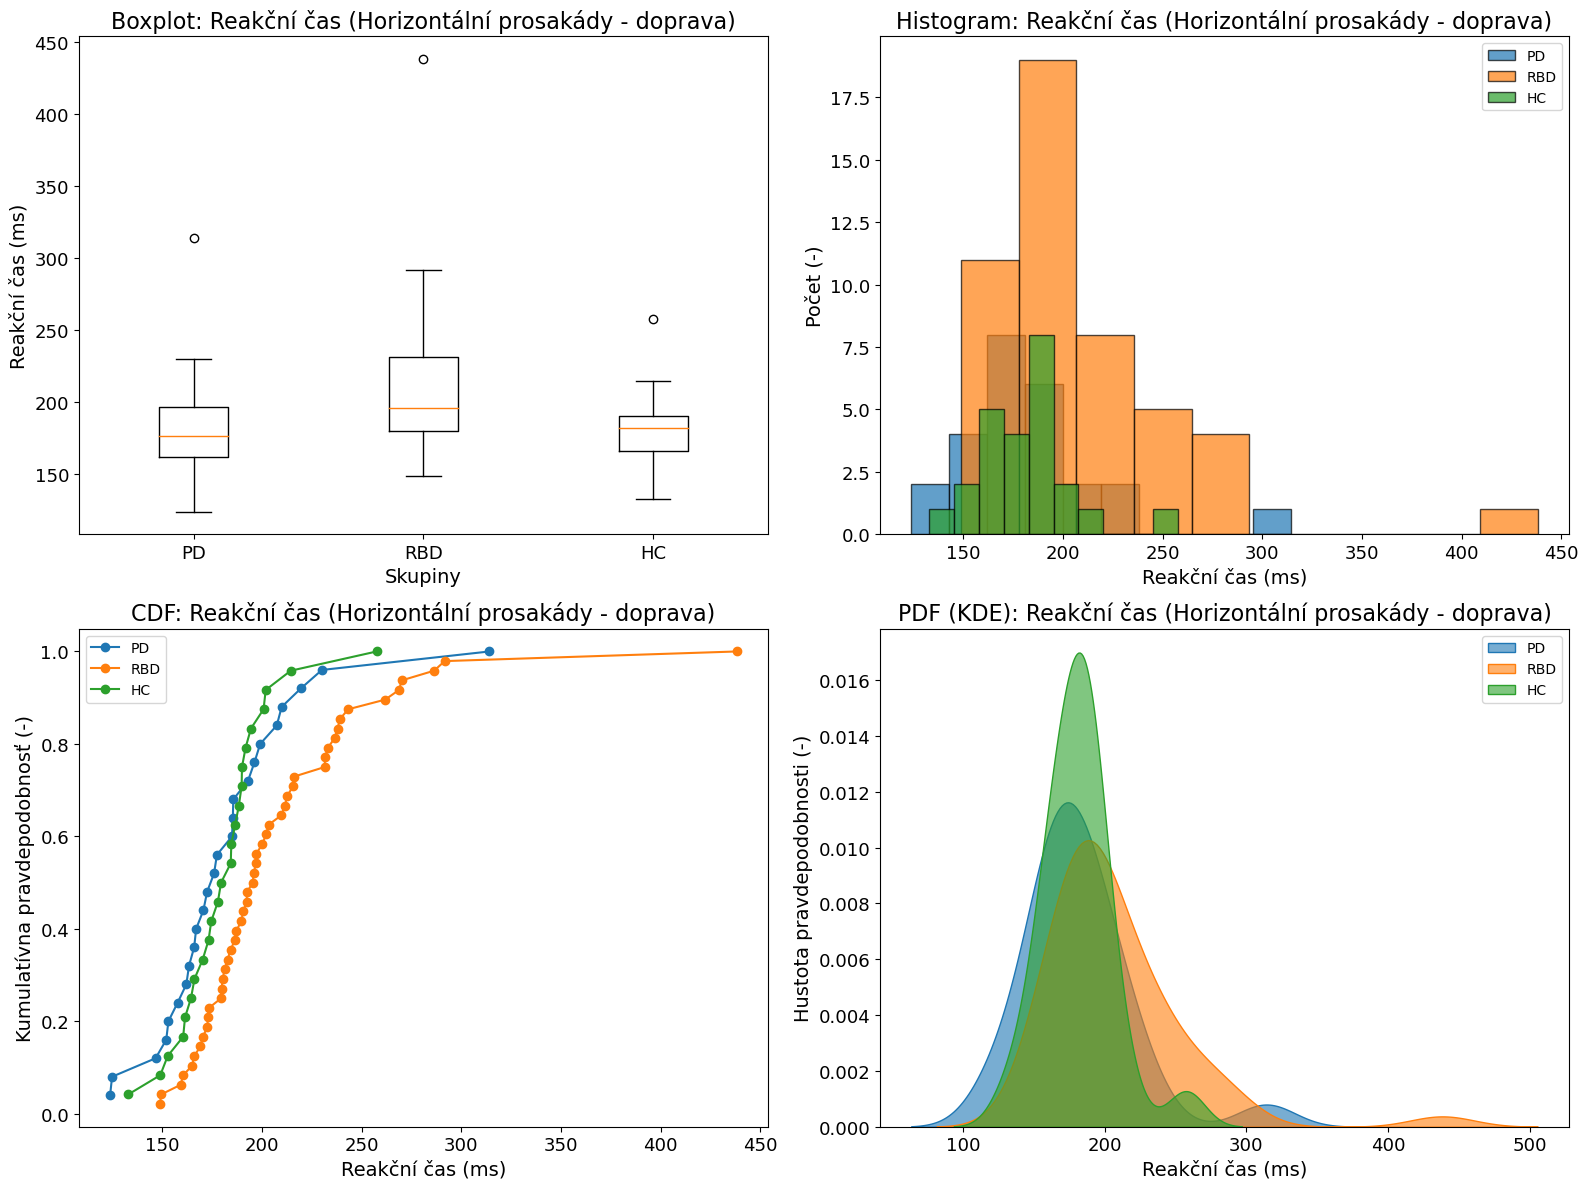


Vizualizácia pre parameter: Průměrná rychlost
Graf uložený ako Průměrná rychlost_Horizontální prosakády - doprava_vizualizacia.png


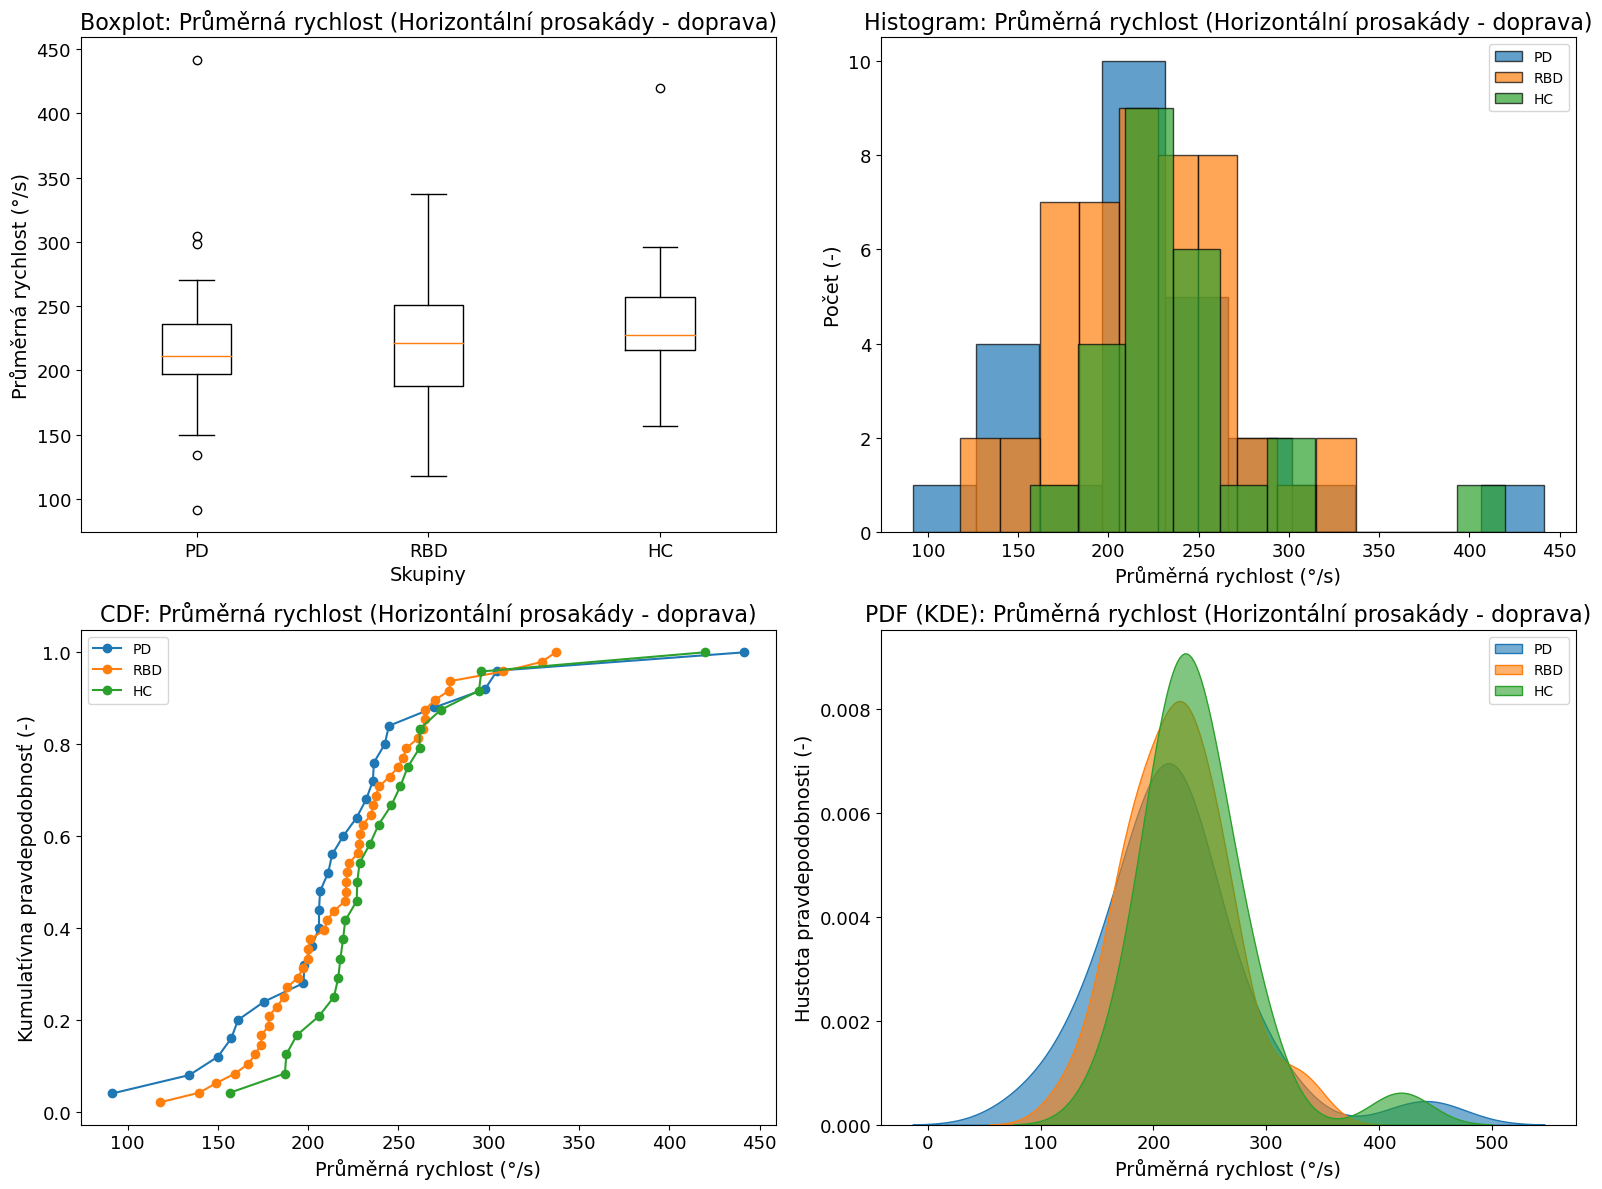


Vizualizácia pre parameter: Maximální rychlost
Graf uložený ako Maximální rychlost_Horizontální prosakády - doprava_vizualizacia.png


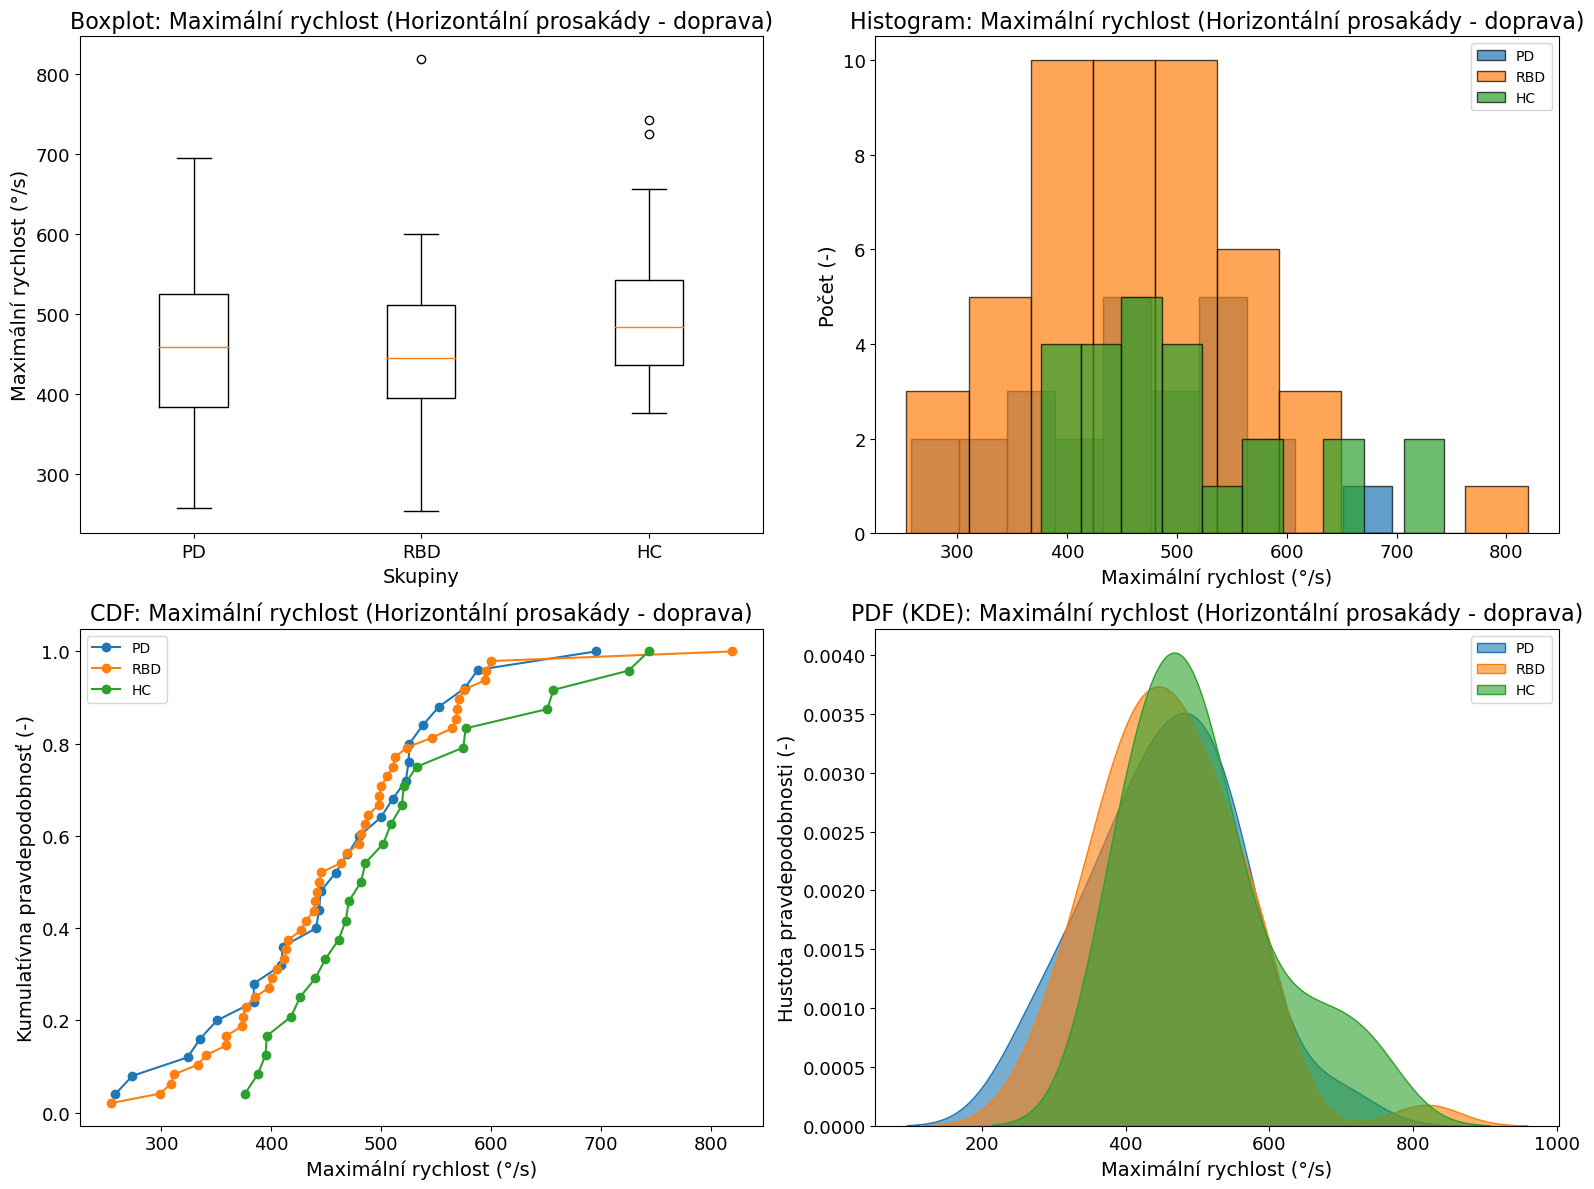


Vizualizácia pre parameter: Zesílení
Graf uložený ako Zesílení_Horizontální prosakády - doprava_vizualizacia.png


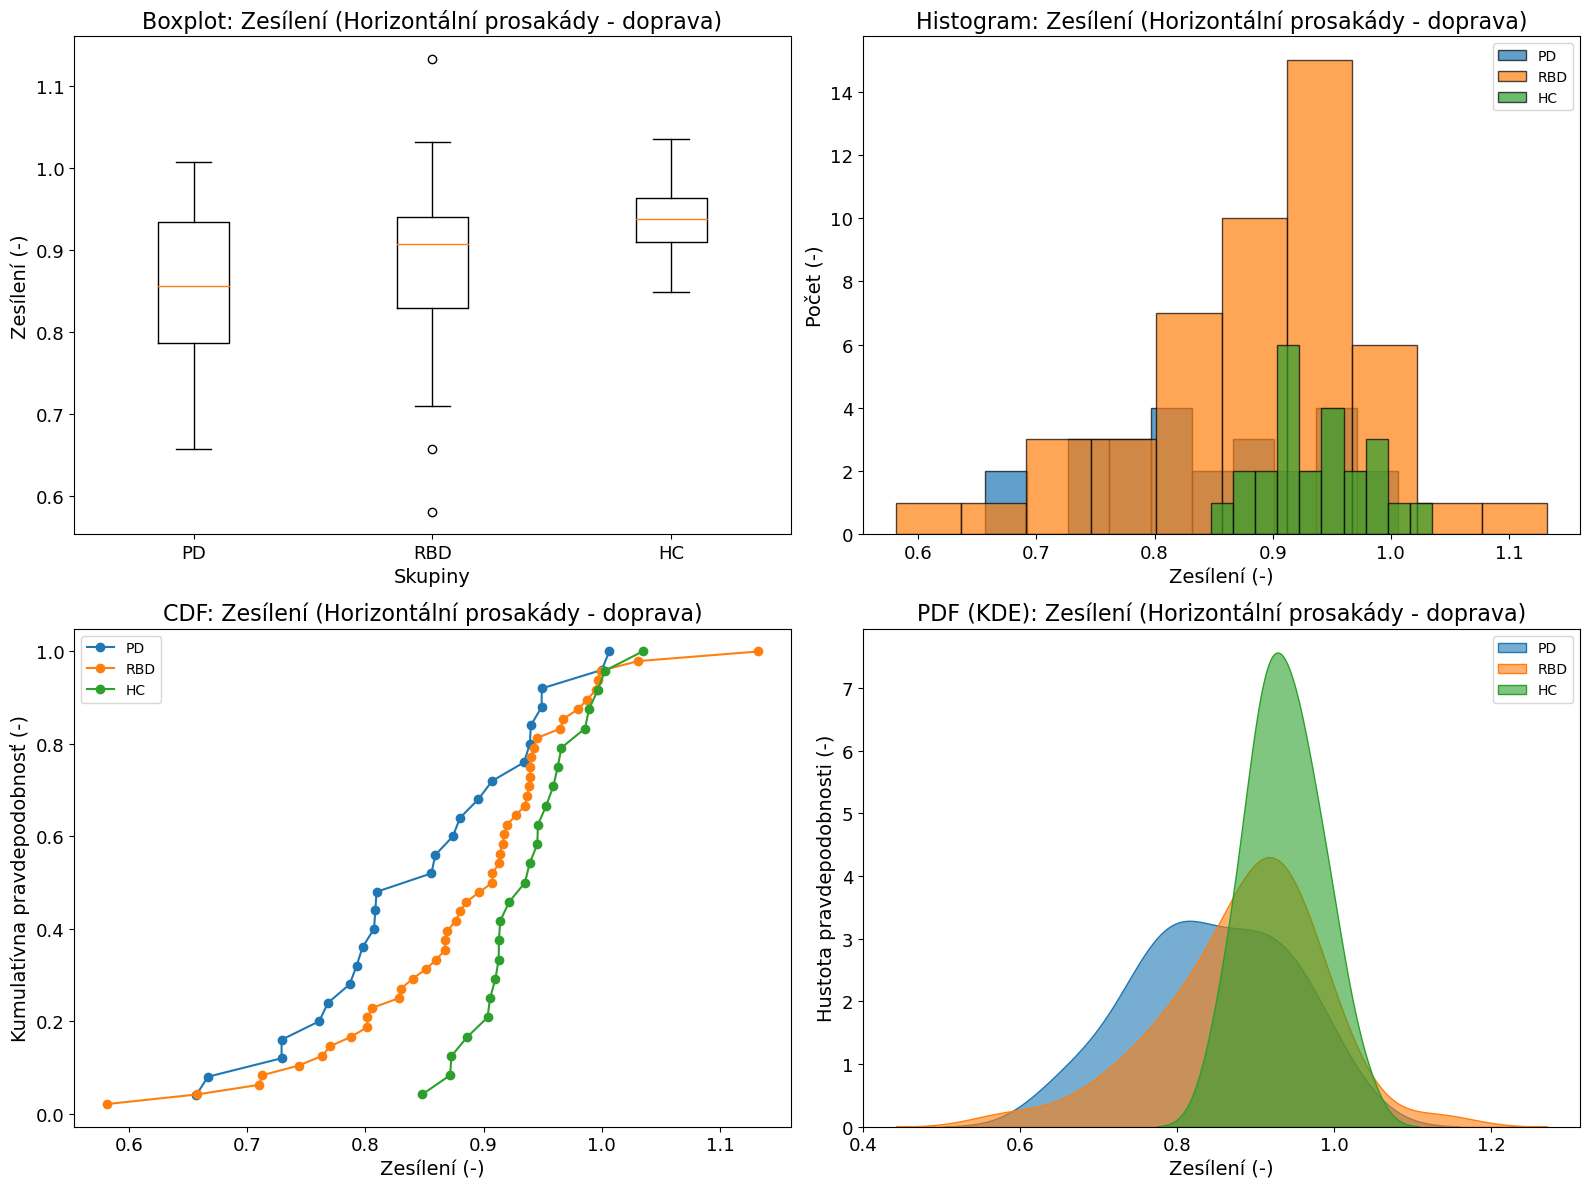


==== Testy pre parameter: Reakční čas ====
Shapiro-Wilk test normálnosti:
  PD: p=5.6404e-03
  RBD: p=8.6393e-07
  HC: p=1.2318e-01
Levene test homogenity variancií: Stat=1.4681, p=2.3559e-01
Kruskal-Wallis: Stat=10.6978, p=4.7535e-03

Post-hoc test (Dunnov test):
          HC        PD       RBD
HC   1.00000  1.000000  0.033360
PD   1.00000  1.000000  0.015401
RBD  0.03336  0.015401  1.000000
Cohenovo d (PD vs RBD): -0.5940
Cohenovo d (RBD vs PD): 0.5940
Cohenovo d (RBD vs HC): 0.6837
Cohenovo d (HC vs RBD): -0.6837

==== Testy pre parameter: Průměrná rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=1.1952e-02
  RBD: p=8.7192e-01
  HC: p=1.9617e-03
Levene test homogenity variancií: Stat=0.5015, p=6.0726e-01
Kruskal-Wallis: Stat=2.6555, p=2.6508e-01

==== Testy pre parameter: Maximální rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=9.6098e-01
  RBD: p=8.1067e-02
  HC: p=3.4159e-02
Levene test homogenity variancií: Stat=0.0361, p=9.6456e-01
Kruskal-Wallis: Stat=3.1097, p=2.11

In [9]:
analyze_data("data.csv", [0, 8, 9, 10, 11], "Horizontální prosakády - doprava")

######################################
#   Horizontální prosakády - DOLEVA  #
######################################


==== Vizualizácia ====

Vizualizácia pre parameter: Reakční čas
Graf uložený ako Reakční čas_Horizontální prosakády - doleva_vizualizacia.png


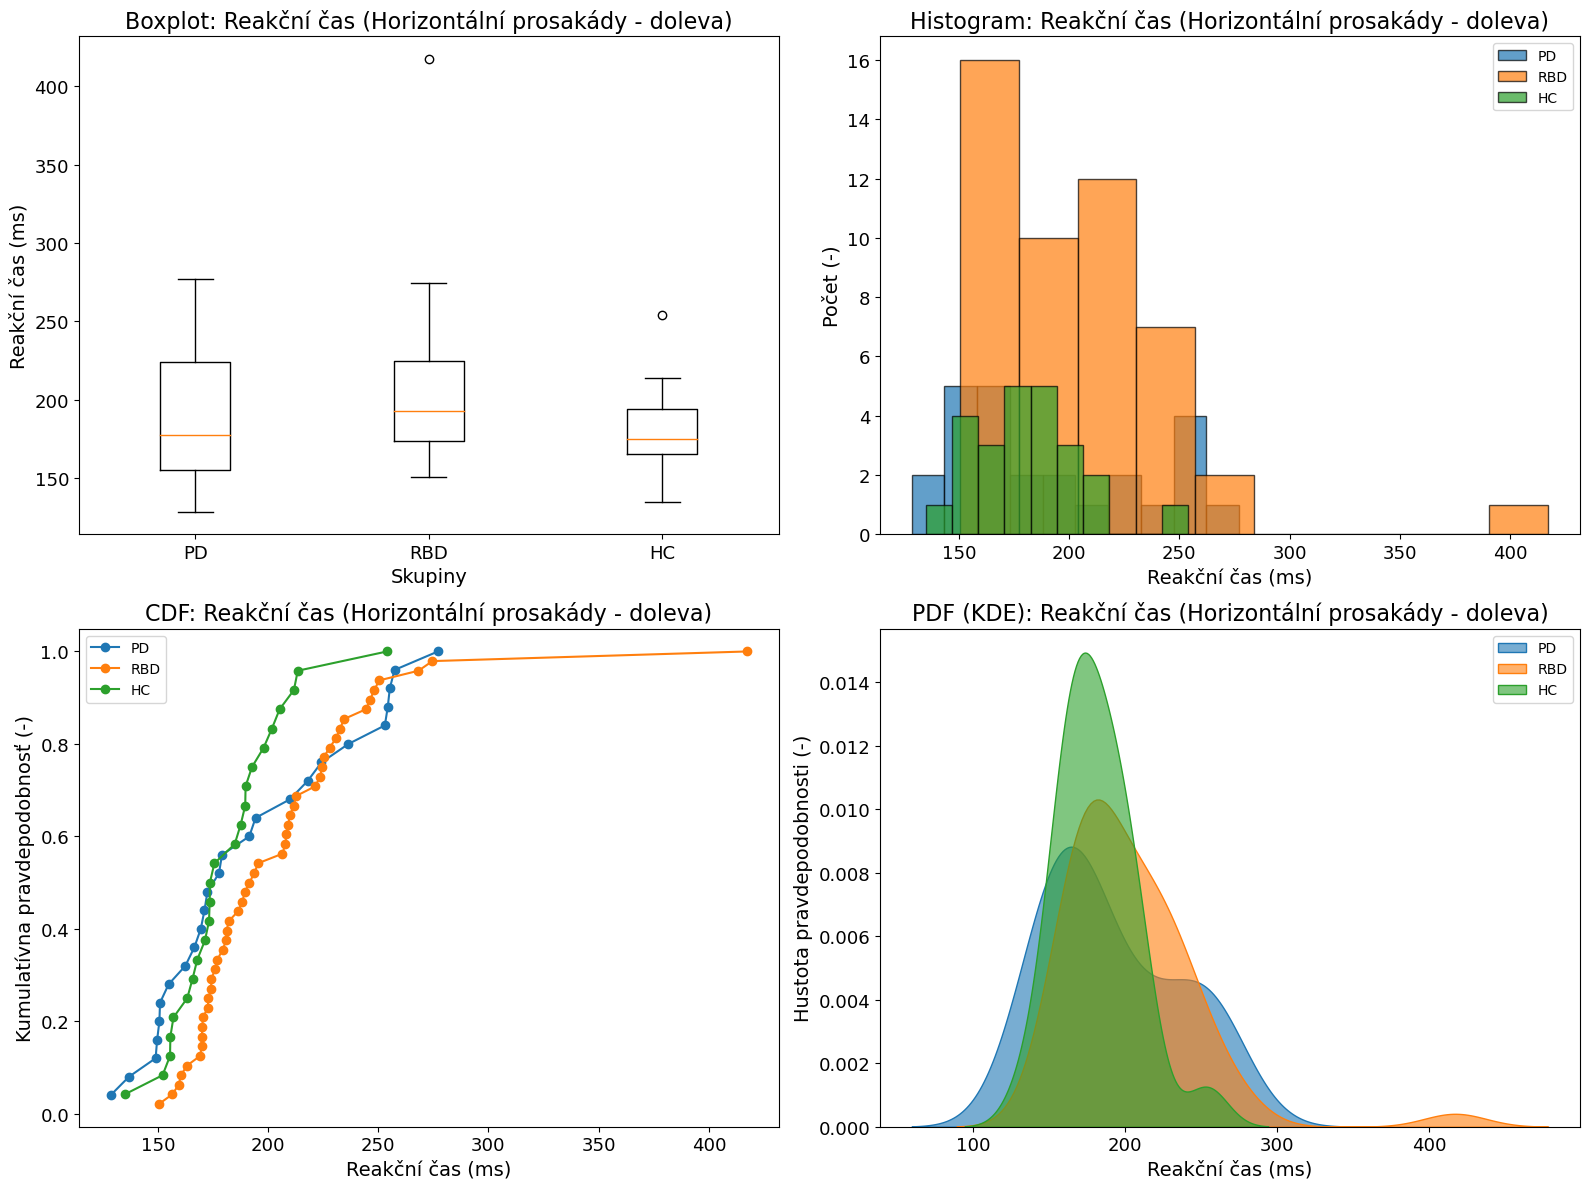


Vizualizácia pre parameter: Průměrná rychlost
Graf uložený ako Průměrná rychlost_Horizontální prosakády - doleva_vizualizacia.png


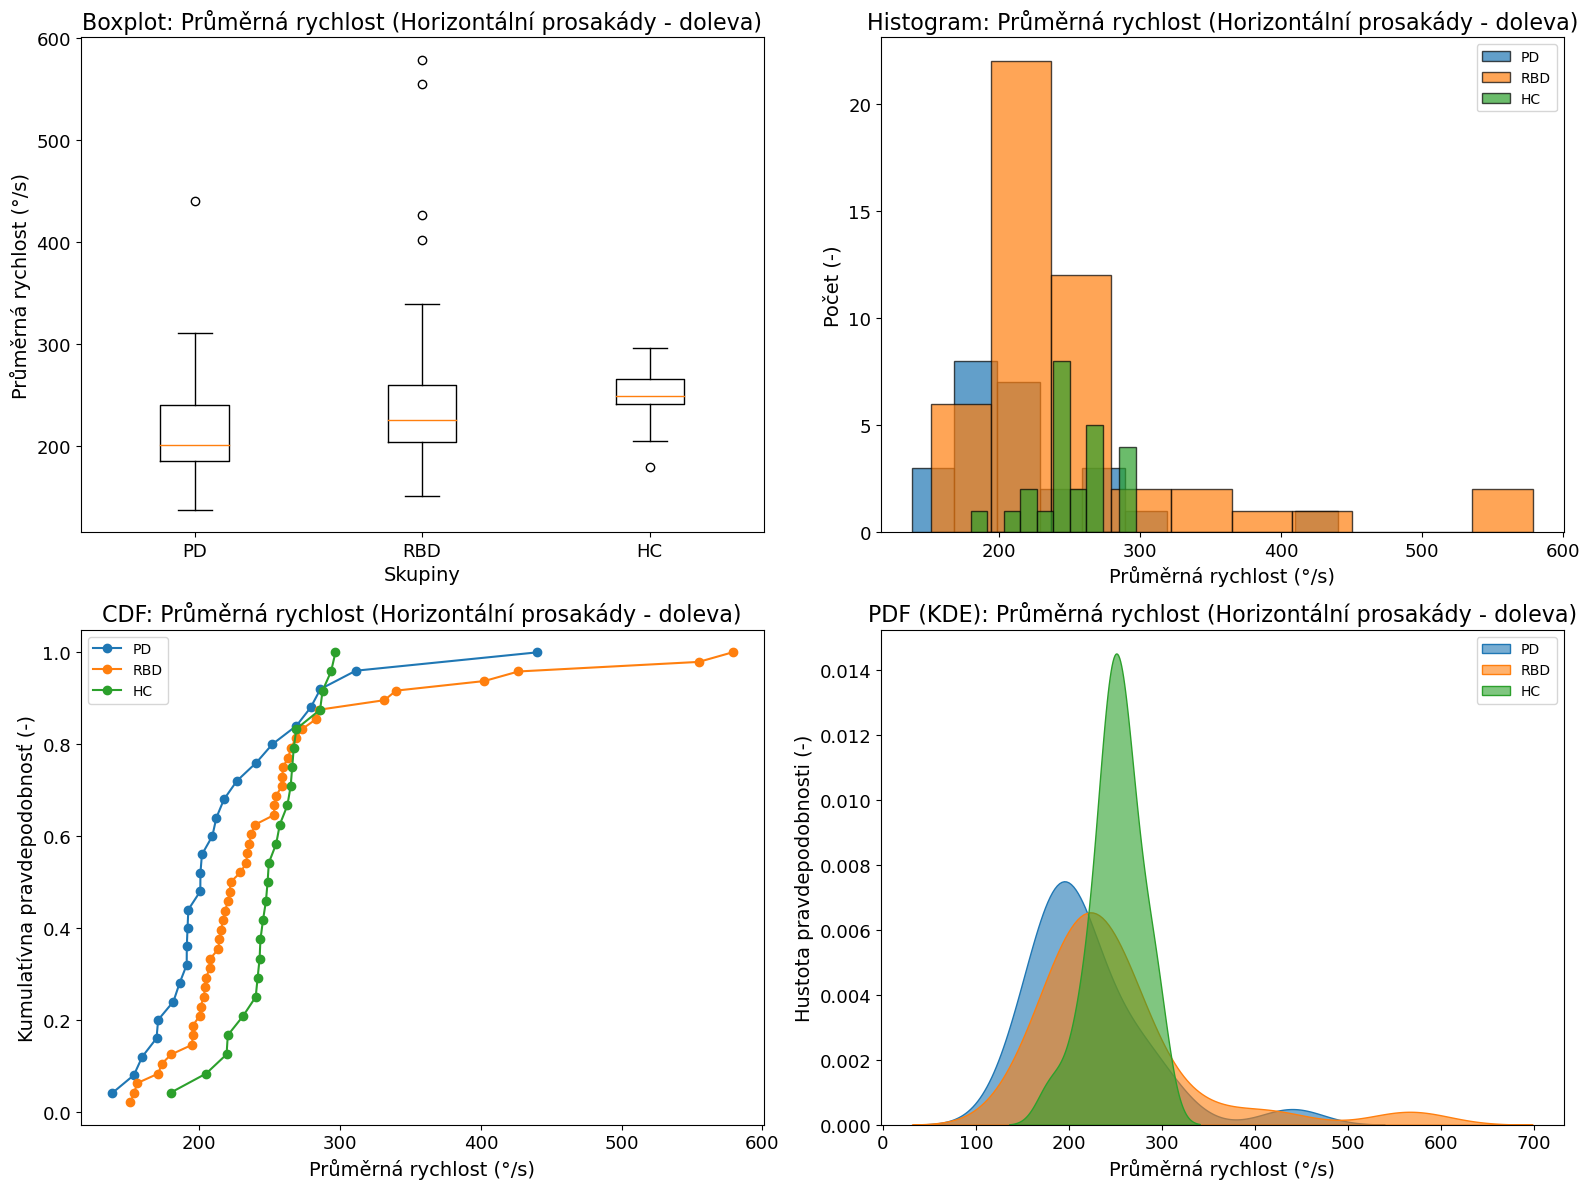


Vizualizácia pre parameter: Maximální rychlost
Graf uložený ako Maximální rychlost_Horizontální prosakády - doleva_vizualizacia.png


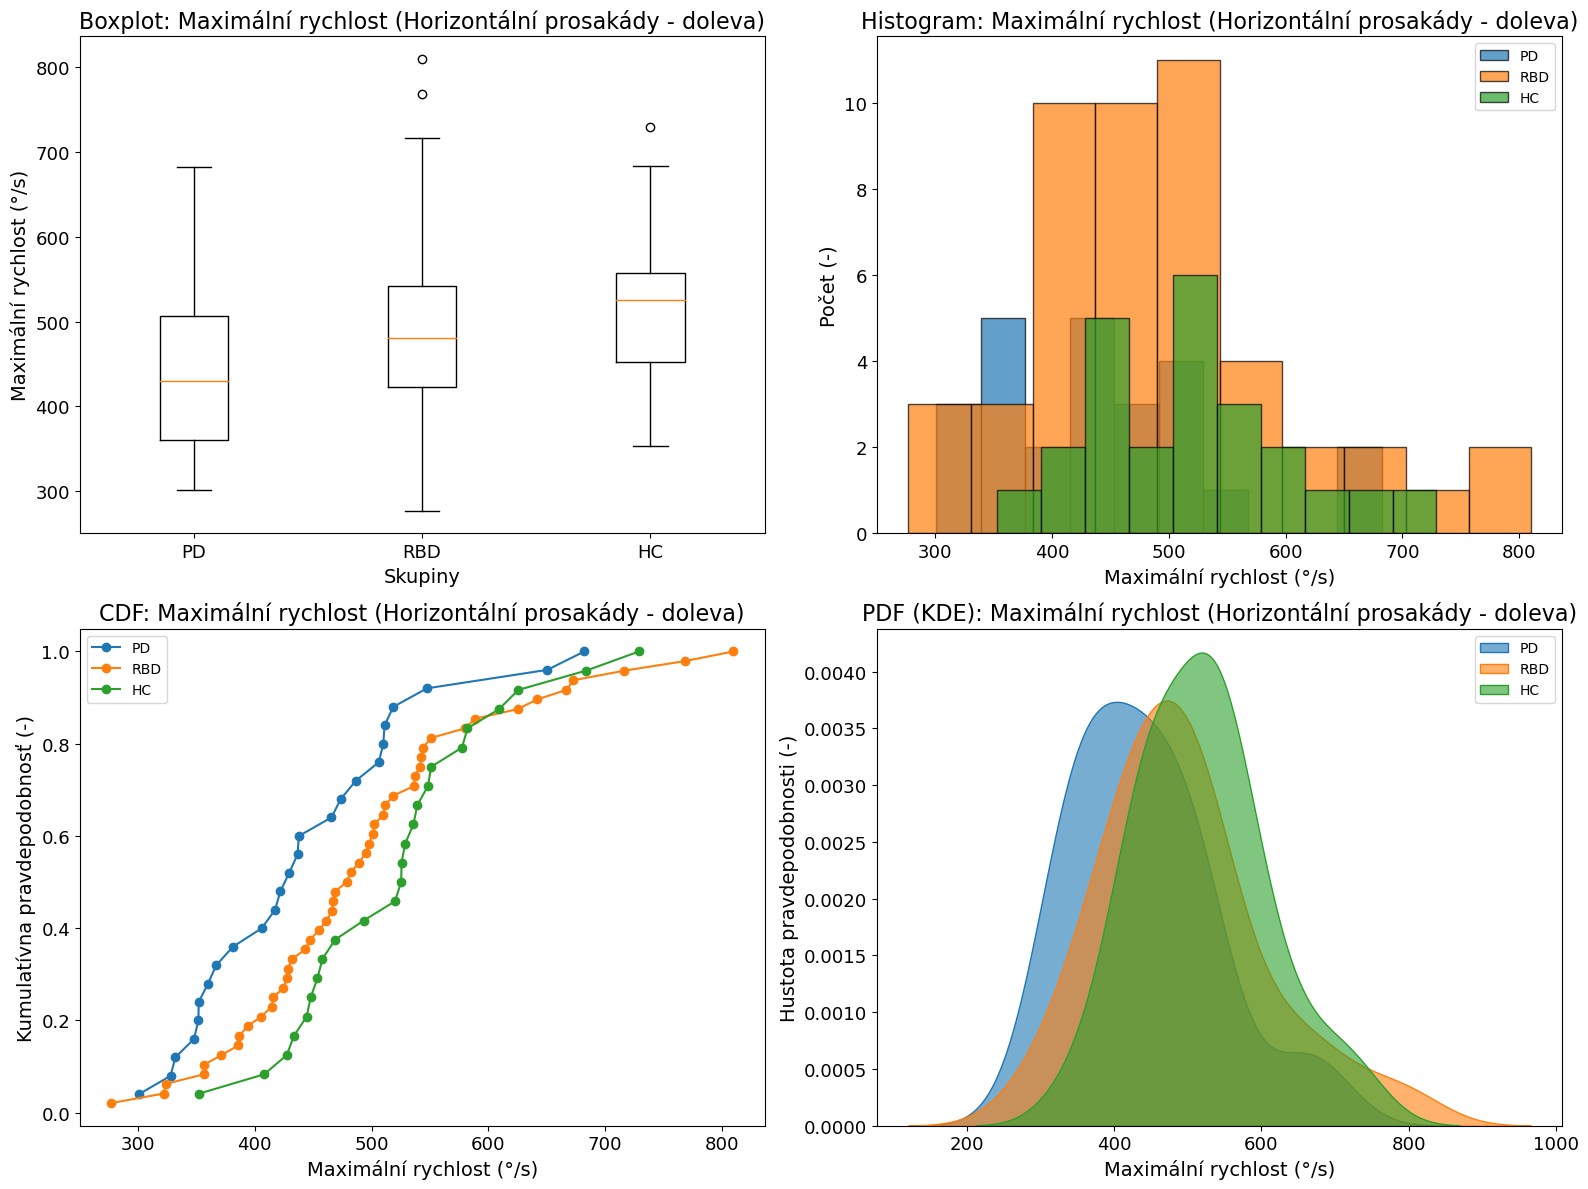


Vizualizácia pre parameter: Zesílení
Graf uložený ako Zesílení_Horizontální prosakády - doleva_vizualizacia.png


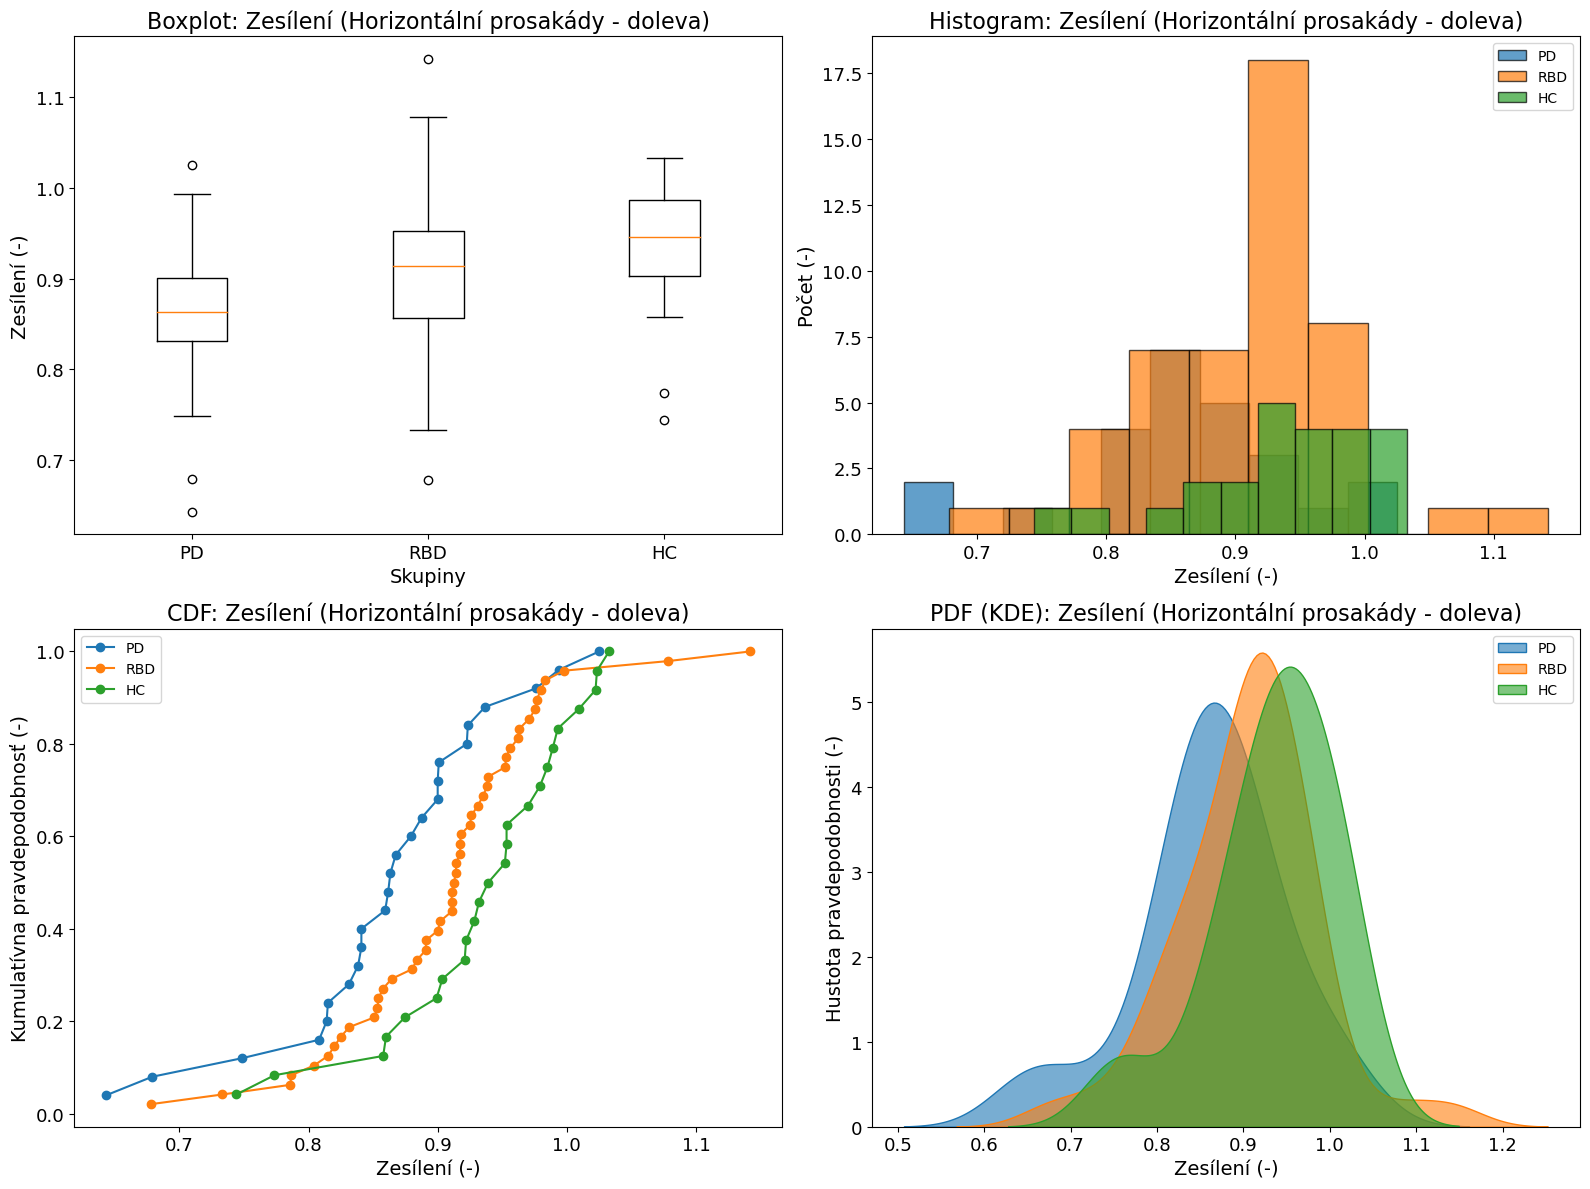


==== Testy pre parameter: Reakční čas ====
Shapiro-Wilk test normálnosti:
  PD: p=5.0090e-02
  RBD: p=8.0566e-07
  HC: p=3.2751e-01
Levene test homogenity variancií: Stat=2.0402, p=1.3572e-01
Kruskal-Wallis: Stat=5.4303, p=6.6195e-02

==== Testy pre parameter: Průměrná rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=8.5899e-04
  RBD: p=8.0267e-08
  HC: p=4.9964e-01
Levene test homogenity variancií: Stat=2.2786, p=1.0806e-01
Kruskal-Wallis: Stat=11.0889, p=3.9092e-03

Post-hoc test (Dunnov test):
           HC        PD       RBD
HC   1.000000  0.002608  0.169654
PD   0.002608  1.000000  0.162590
RBD  0.169654  0.162590  1.000000
Cohenovo d (PD vs HC): -0.6553
Cohenovo d (HC vs PD): 0.6553

==== Testy pre parameter: Maximální rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=1.1291e-01
  RBD: p=8.4596e-02
  HC: p=7.2460e-01
Levene test homogenity variancií: Stat=0.5352, p=5.8734e-01
ANOVA: Stat=3.7596, p=2.6870e-02

Post-hoc test (Tukey HSD):
  Multiple Comparison of Means - Tu

In [12]:
analyze_data("data.csv", [0, 12, 13, 14, 15], "Horizontální prosakády - doleva")

####################################
#   Vertikální prosakády - NAHORU  #
####################################


==== Vizualizácia ====

Vizualizácia pre parameter: Reakční čas
Graf uložený ako Reakční čas_Vertikální prosakády - nahoru_vizualizacia.png


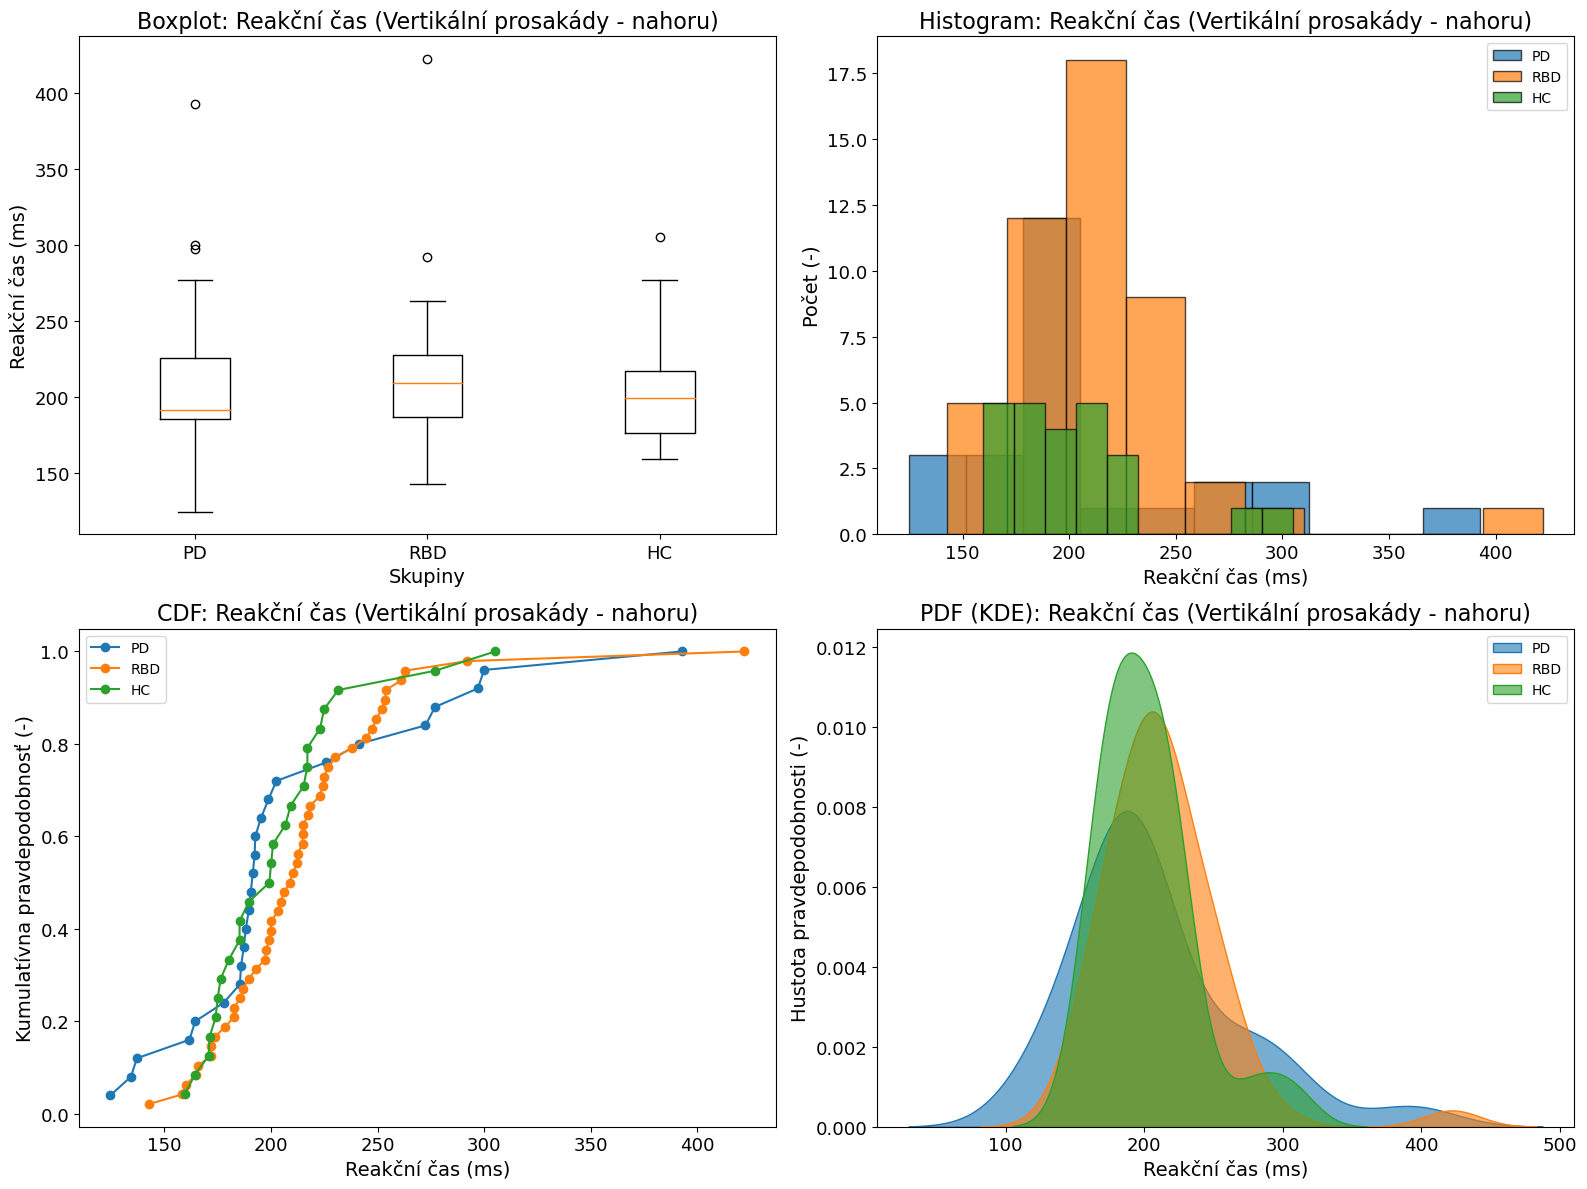


Vizualizácia pre parameter: Průměrná rychlost
Graf uložený ako Průměrná rychlost_Vertikální prosakády - nahoru_vizualizacia.png


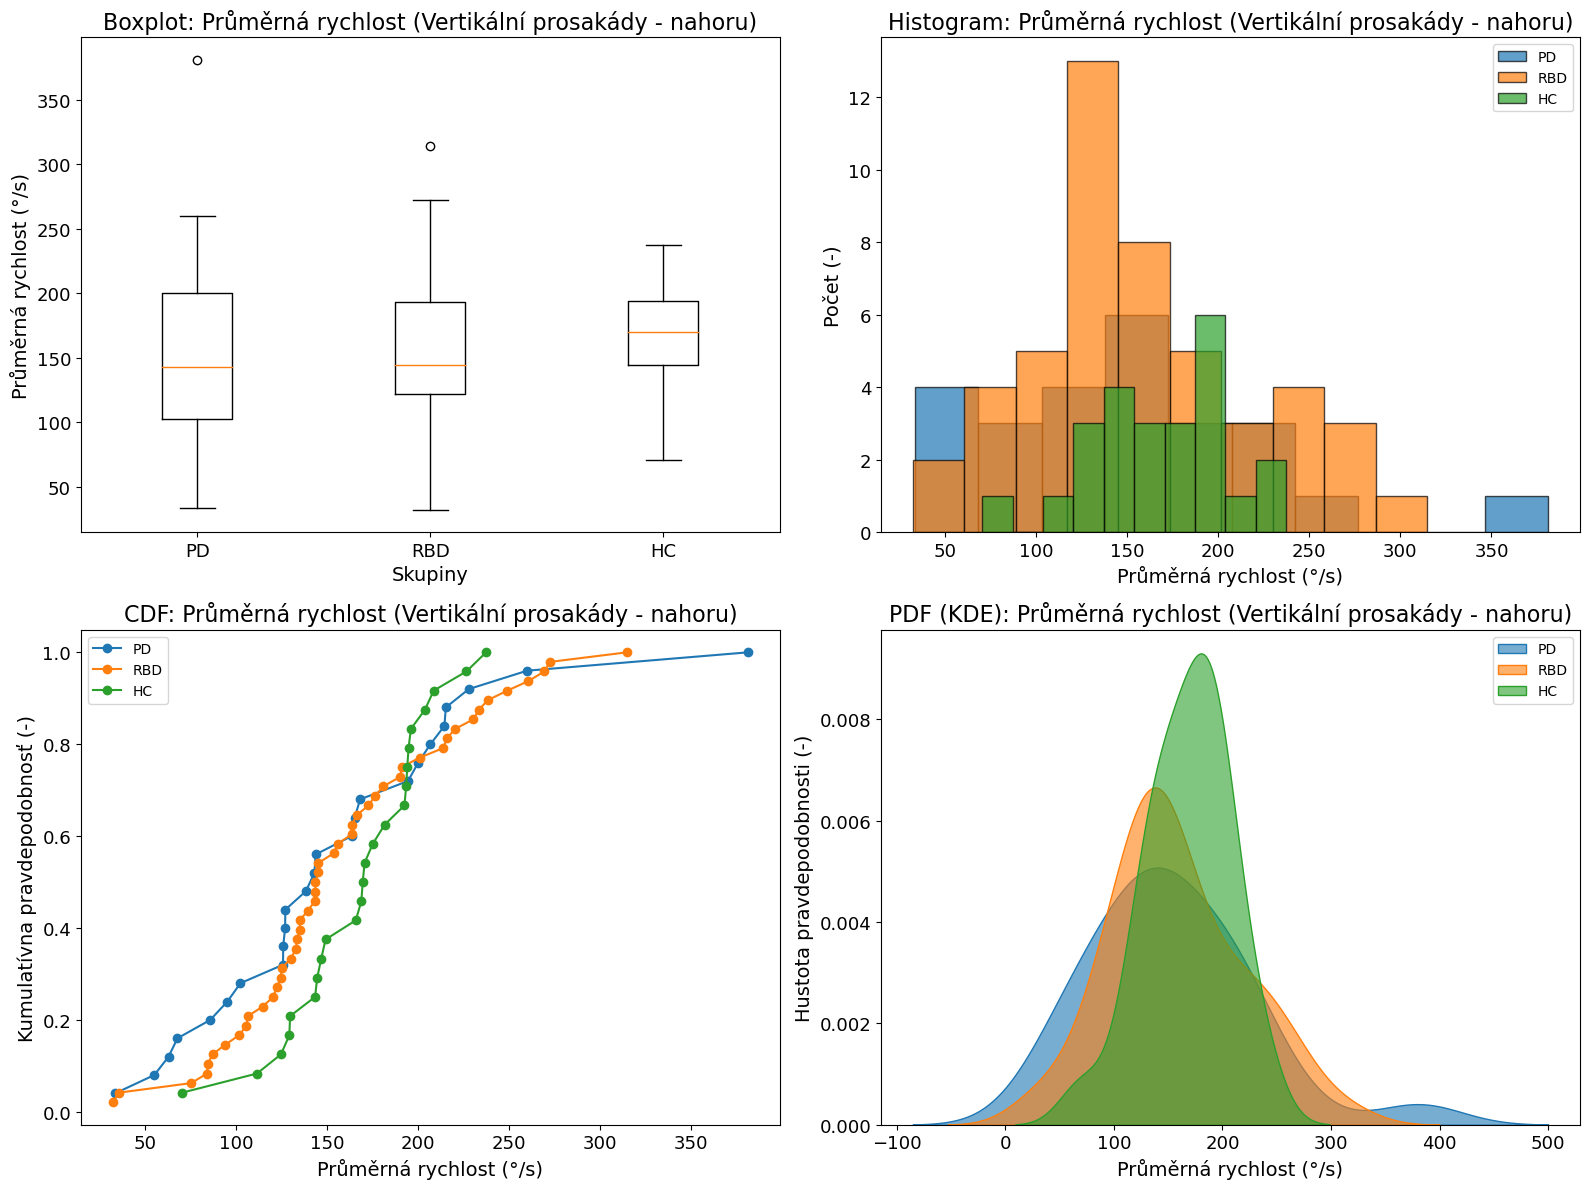


Vizualizácia pre parameter: Maximální rychlost
Graf uložený ako Maximální rychlost_Vertikální prosakády - nahoru_vizualizacia.png


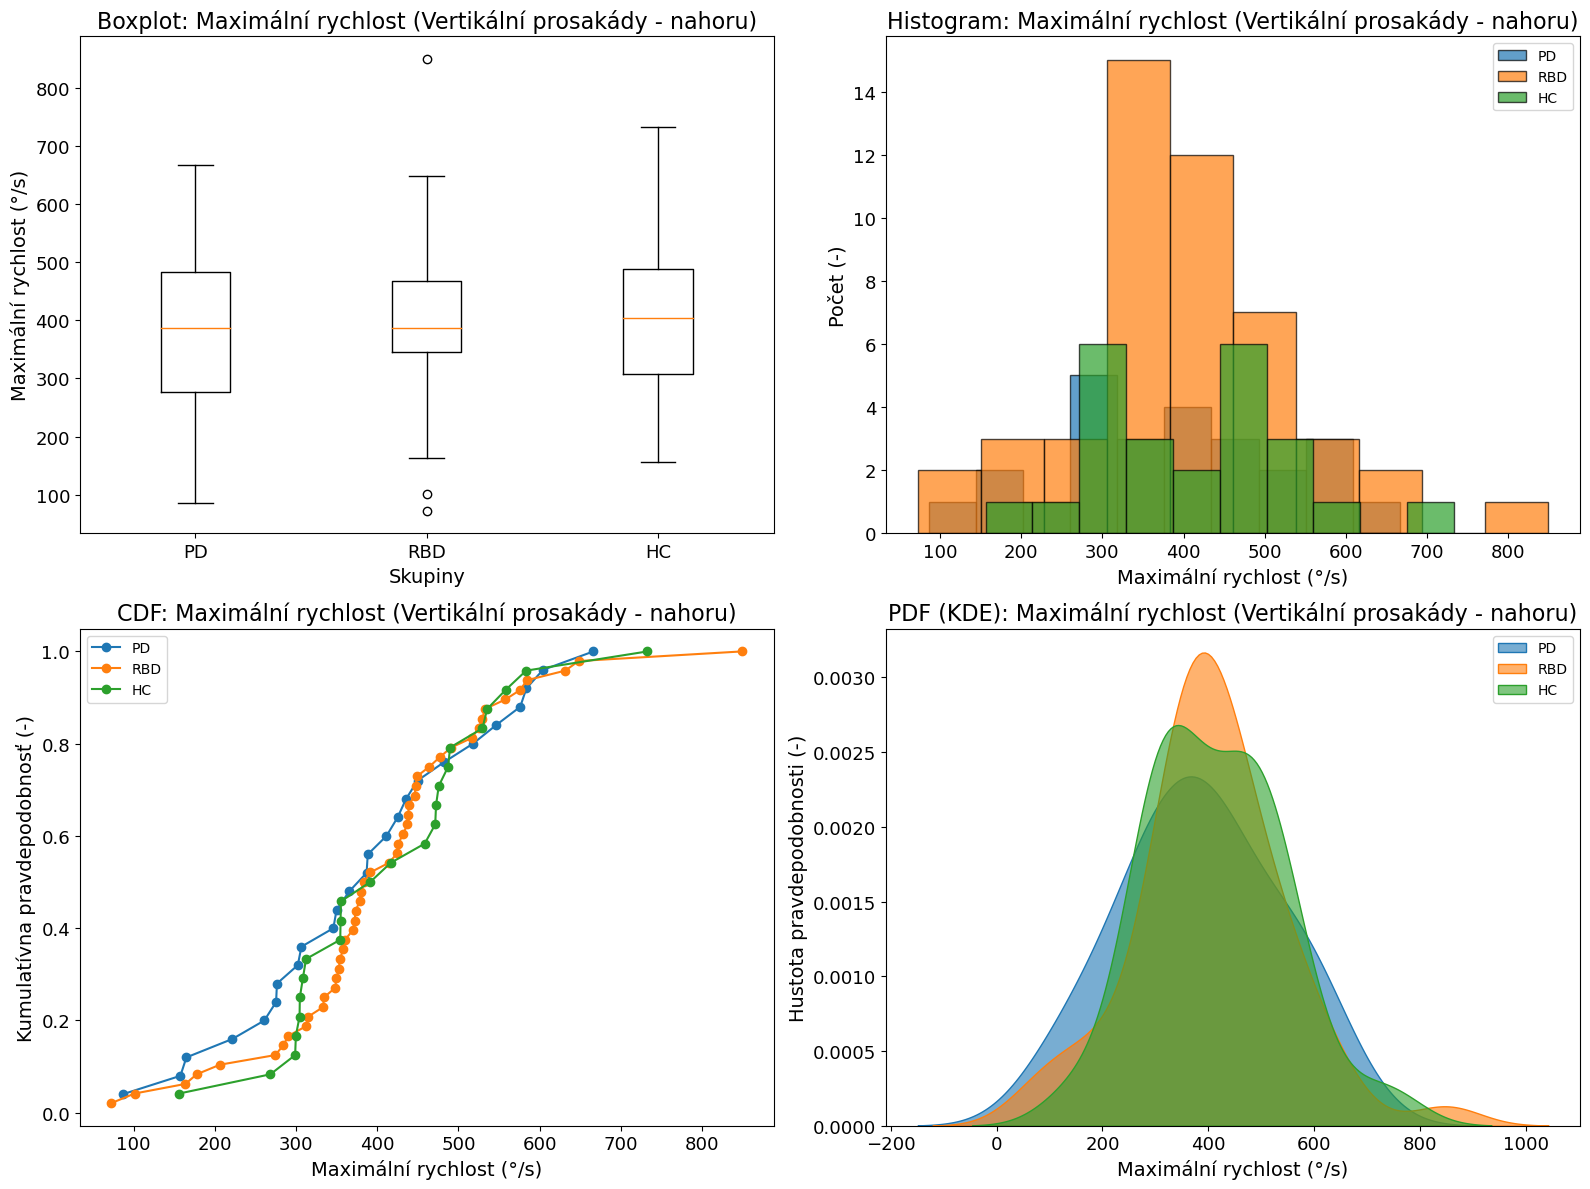


Vizualizácia pre parameter: Zesílení
Graf uložený ako Zesílení_Vertikální prosakády - nahoru_vizualizacia.png


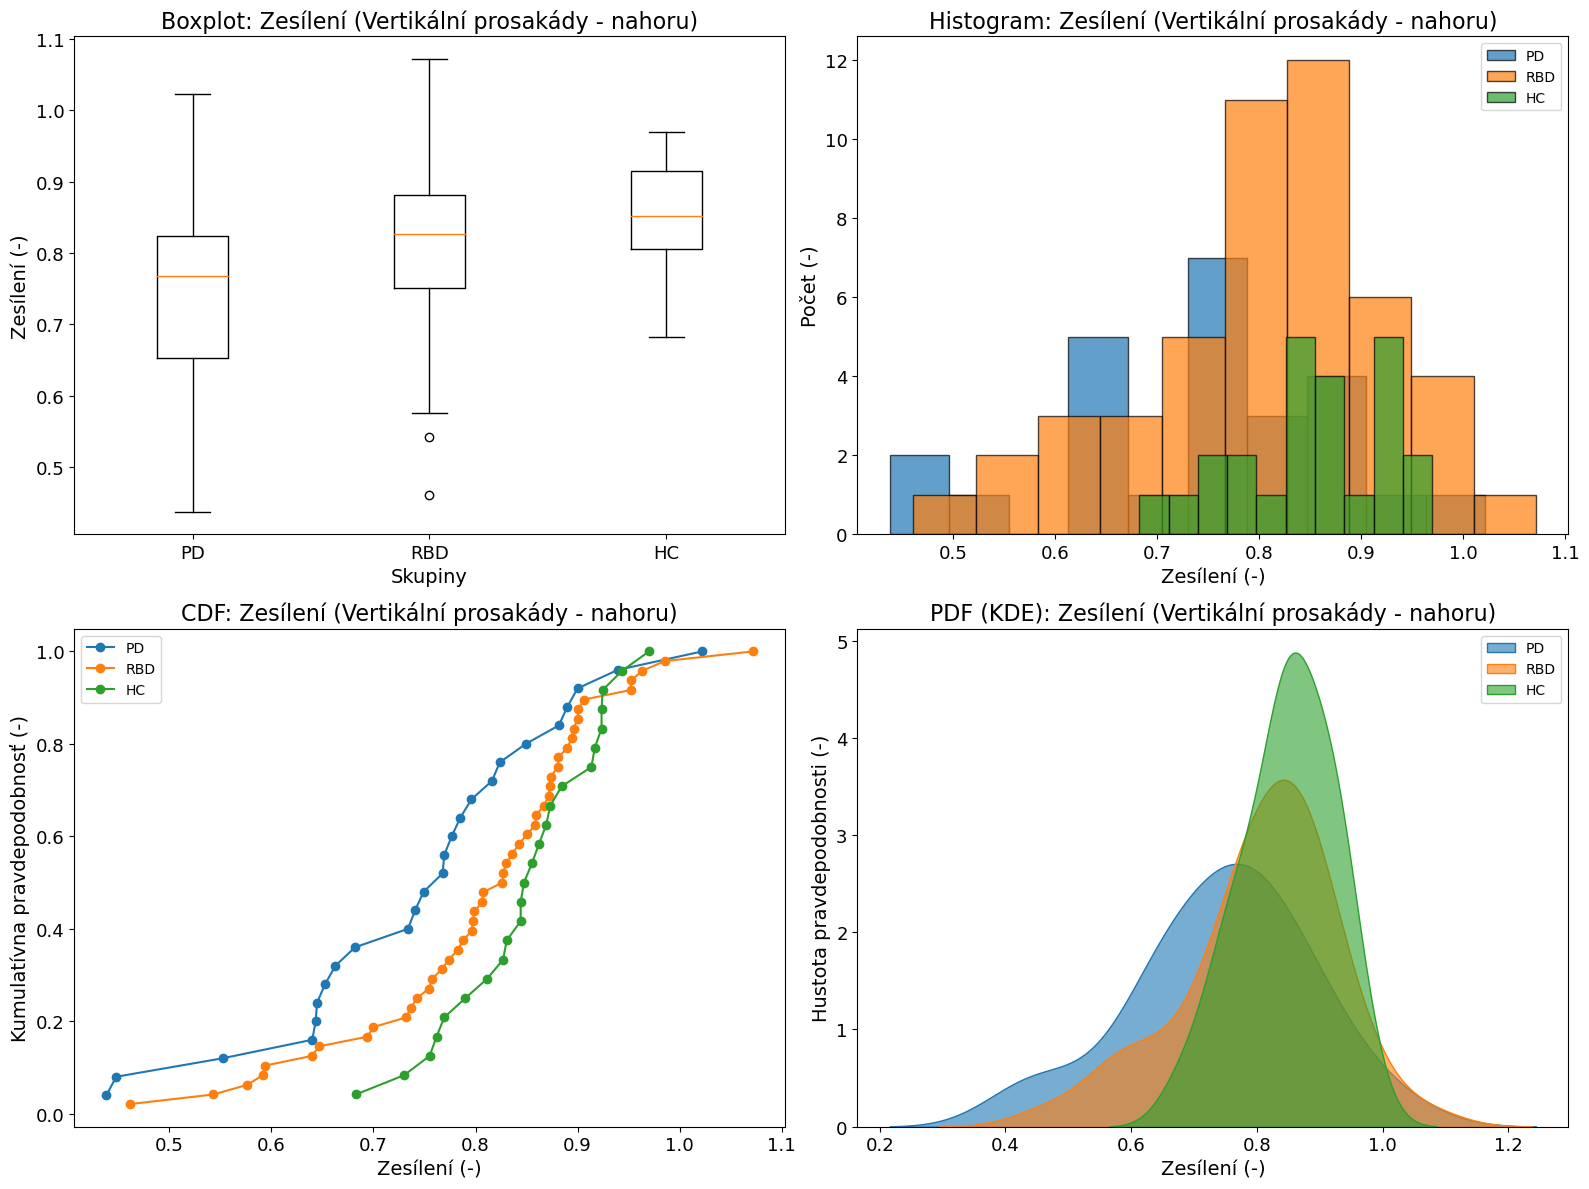


==== Testy pre parameter: Reakční čas ====
Shapiro-Wilk test normálnosti:
  PD: p=3.0310e-03
  RBD: p=7.4735e-06
  HC: p=6.5351e-03
Levene test homogenity variancií: Stat=0.9395, p=3.9446e-01
Kruskal-Wallis: Stat=2.2995, p=3.1672e-01

==== Testy pre parameter: Průměrná rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=1.4742e-01
  RBD: p=4.4375e-01
  HC: p=7.8424e-01
Levene test homogenity variancií: Stat=2.5915, p=8.0253e-02
ANOVA: Stat=0.3726, p=6.8995e-01

==== Testy pre parameter: Maximální rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=9.7839e-01
  RBD: p=1.7564e-01
  HC: p=4.8904e-01
Levene test homogenity variancií: Stat=0.3237, p=7.2430e-01
ANOVA: Stat=0.2985, p=7.4266e-01

==== Testy pre parameter: Zesílení ====
Shapiro-Wilk test normálnosti:
  PD: p=6.5906e-01
  RBD: p=7.6151e-02
  HC: p=6.7664e-01
Levene test homogenity variancií: Stat=2.5952, p=7.9973e-02
ANOVA: Stat=4.8814, p=9.6170e-03

Post-hoc test (Tukey HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.

In [17]:
analyze_data("data.csv", [0, 16, 17, 18, 19], "Vertikální prosakády - nahoru")

##################################
#   Vertikální prosakády - DOLŮ  #
##################################


==== Vizualizácia ====

Vizualizácia pre parameter: Reakční čas
Graf uložený ako Reakční čas_Vertikální prosakády - dolů_vizualizacia.png


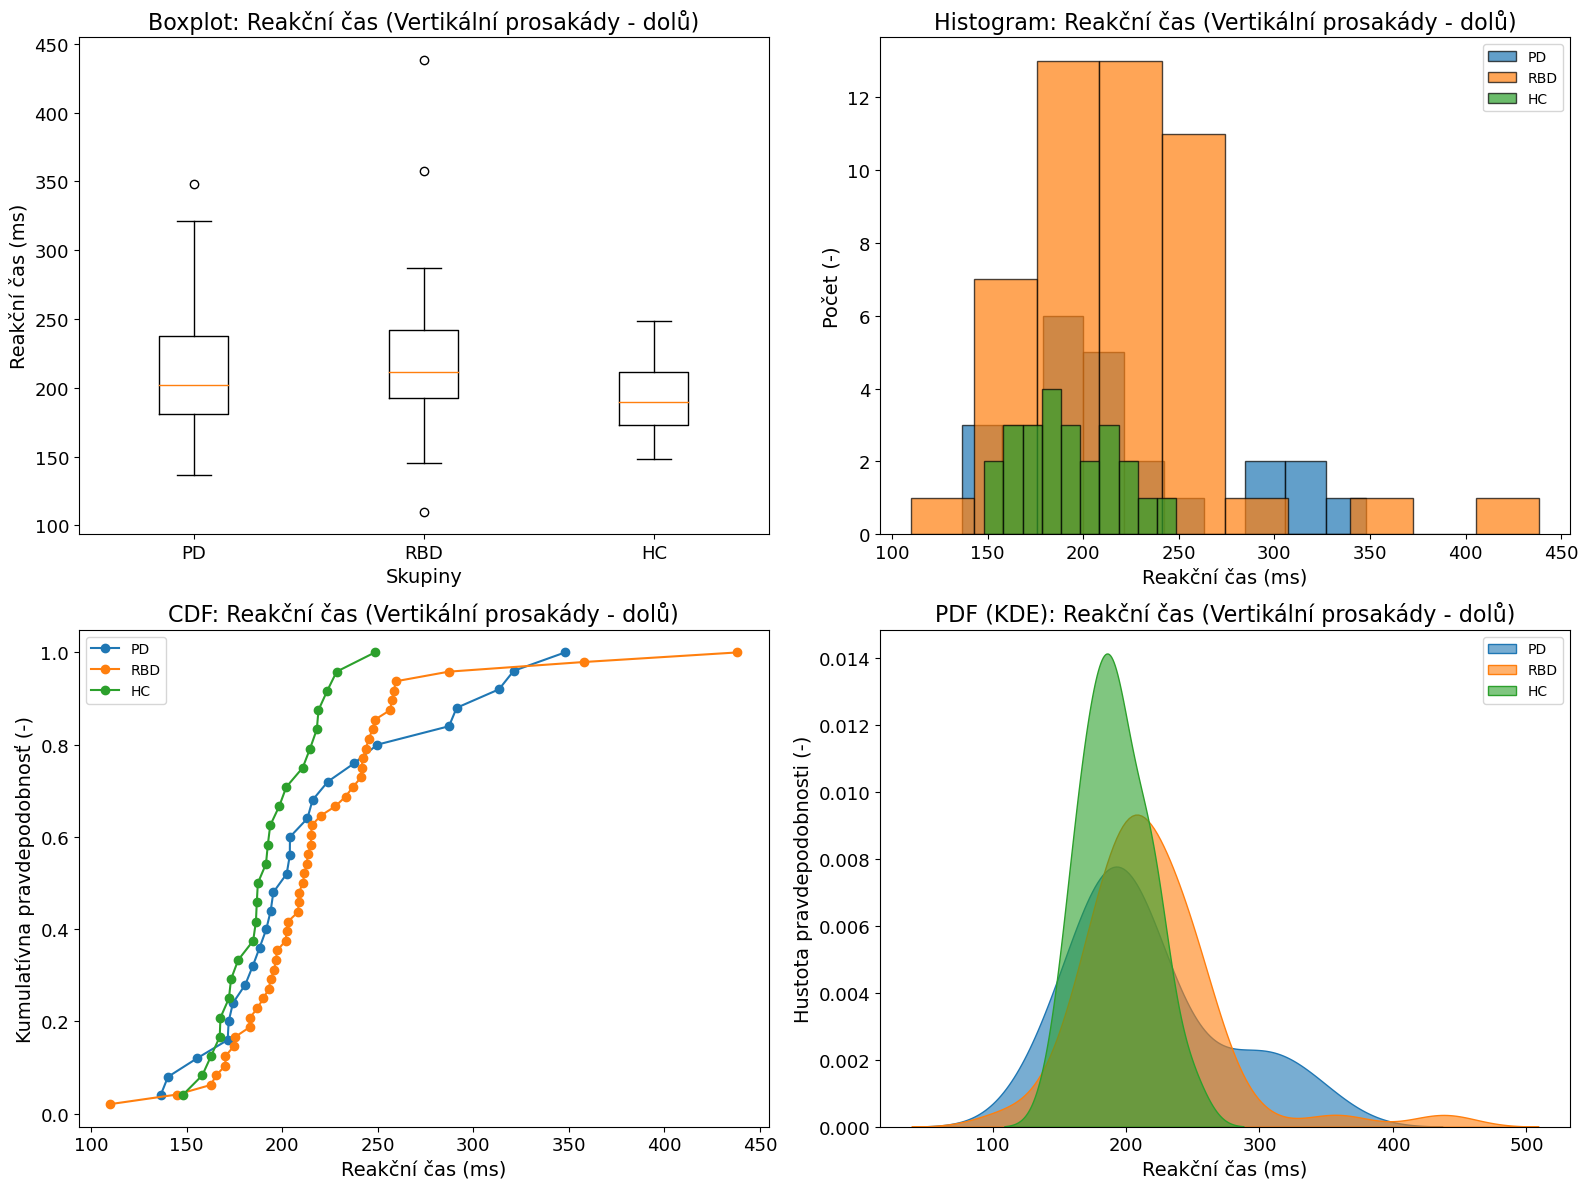


Vizualizácia pre parameter: Průměrná rychlost
Graf uložený ako Průměrná rychlost_Vertikální prosakády - dolů_vizualizacia.png


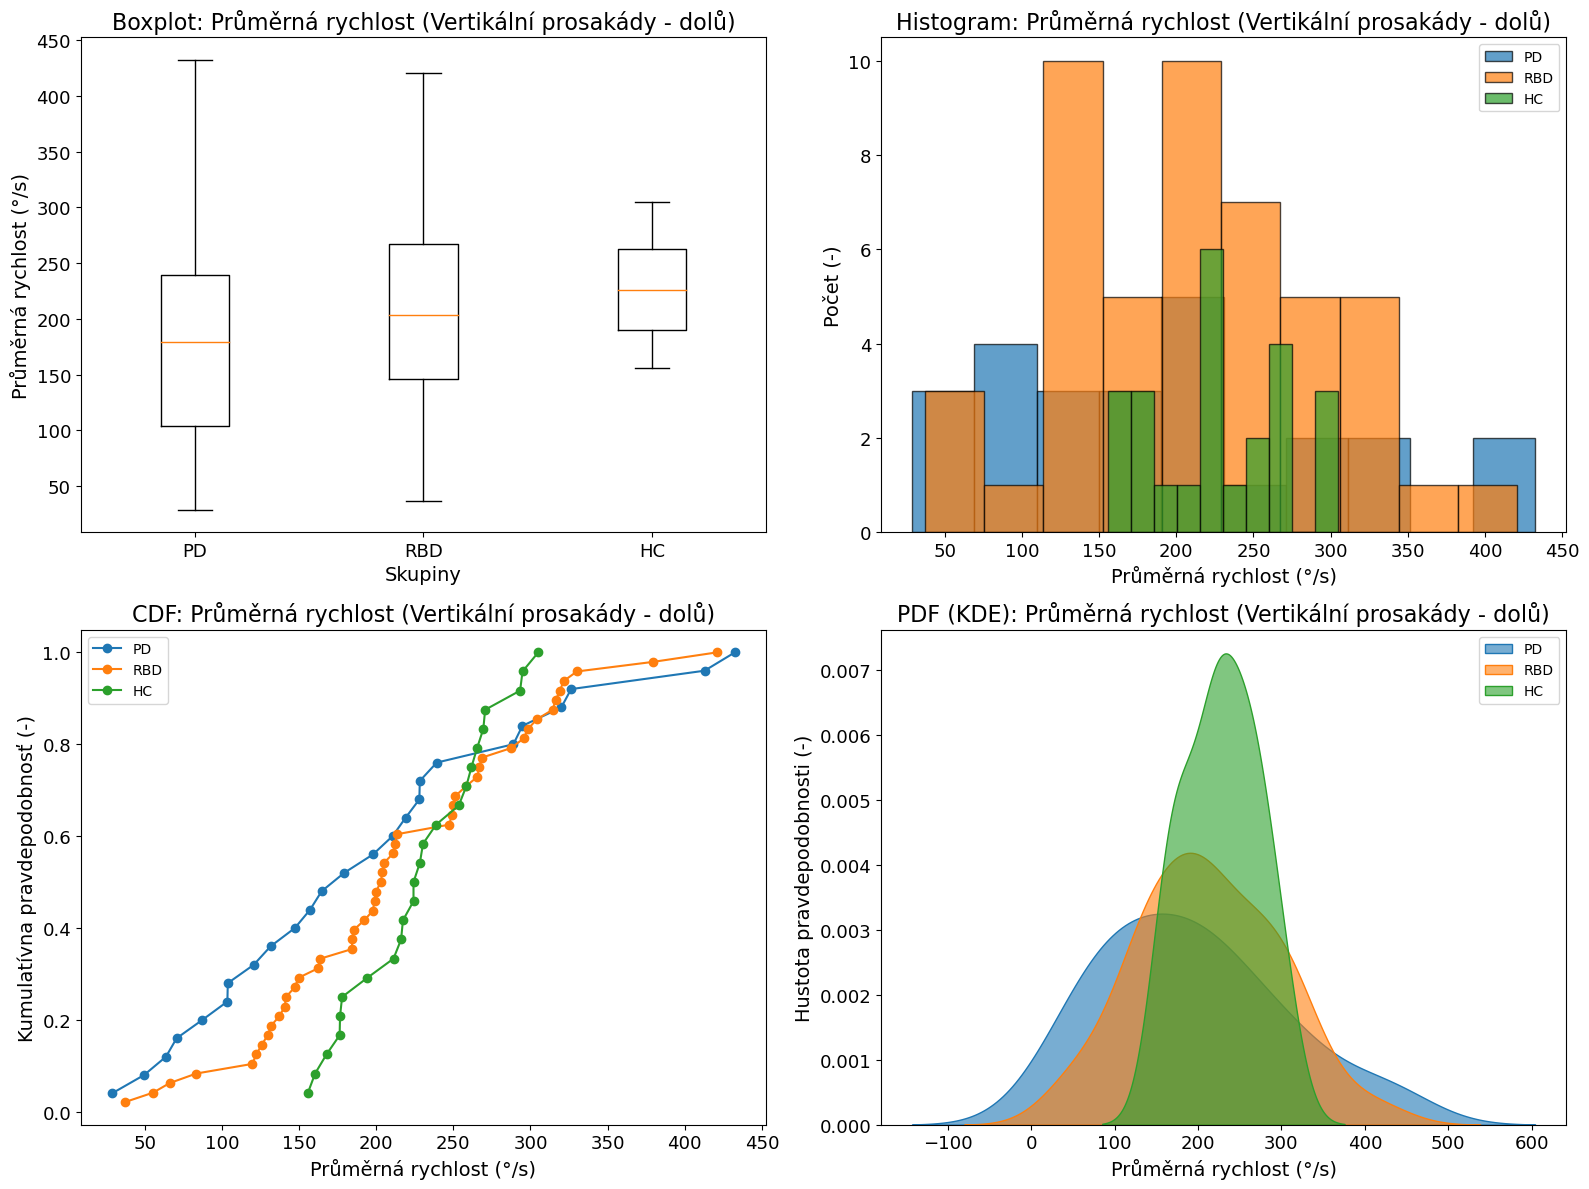


Vizualizácia pre parameter: Maximální rychlost
Graf uložený ako Maximální rychlost_Vertikální prosakády - dolů_vizualizacia.png


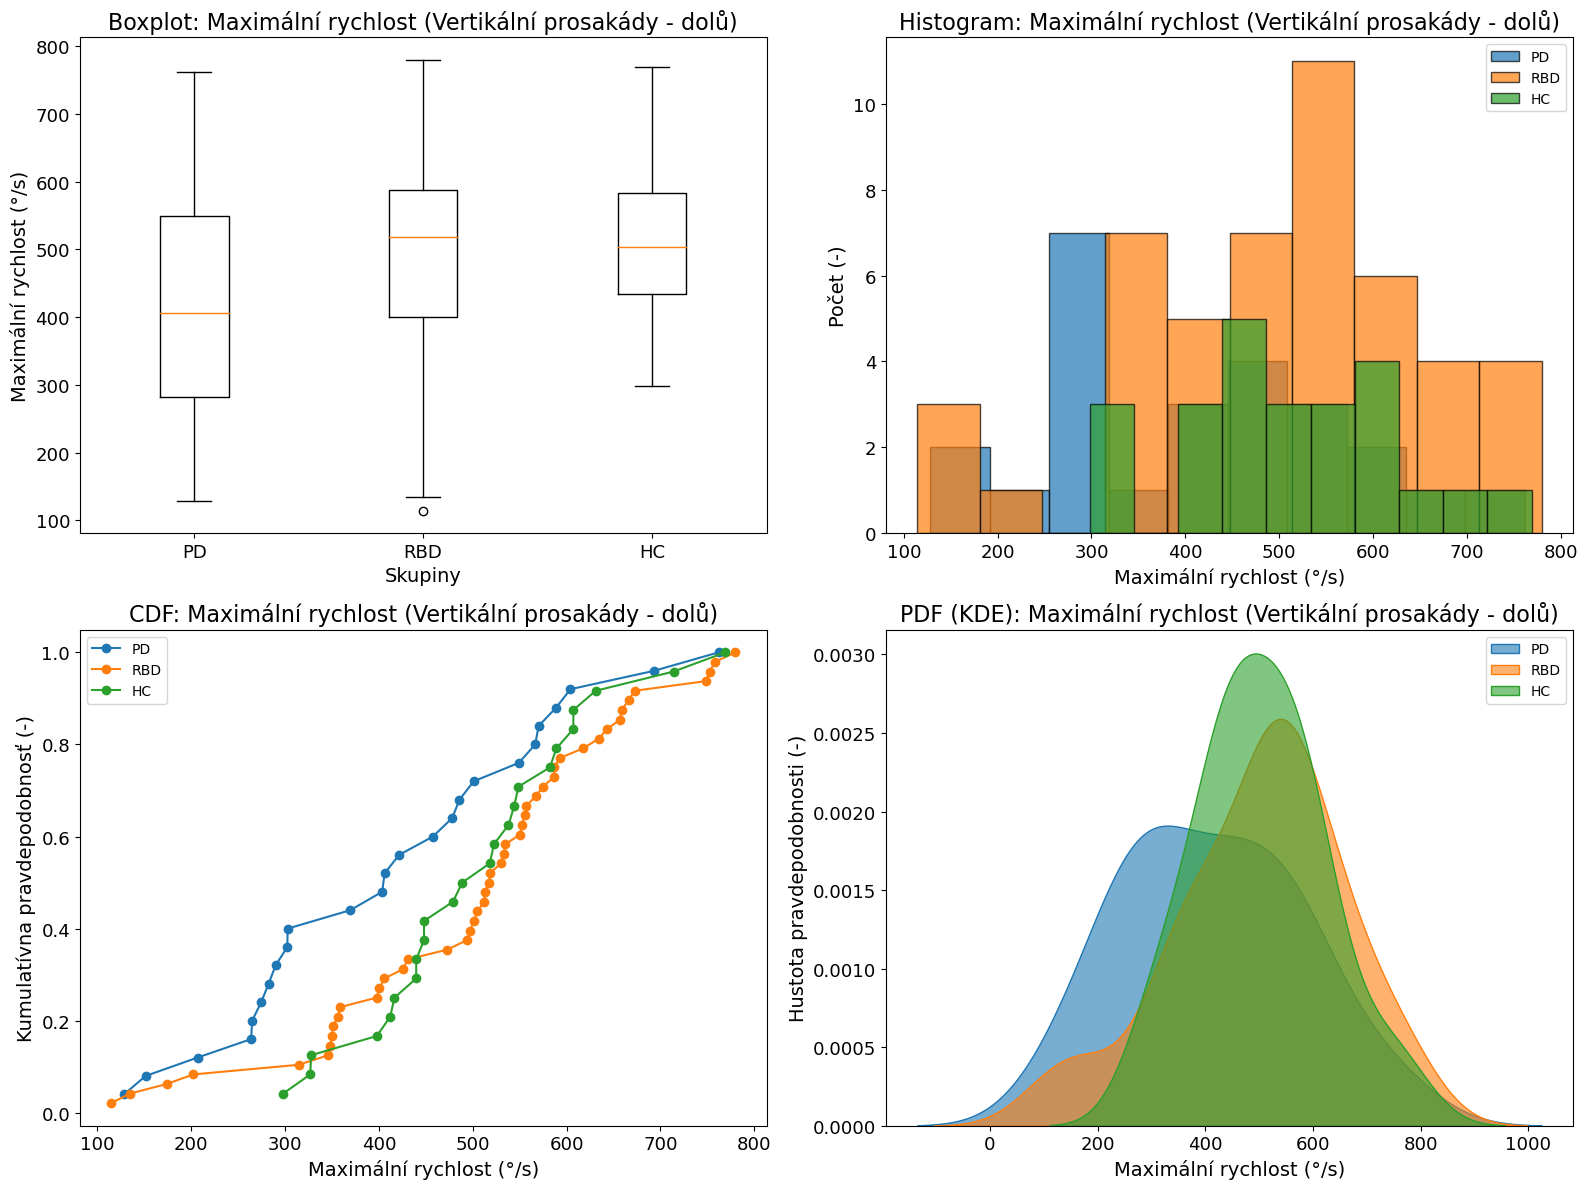


Vizualizácia pre parameter: Zesílení
Graf uložený ako Zesílení_Vertikální prosakády - dolů_vizualizacia.png


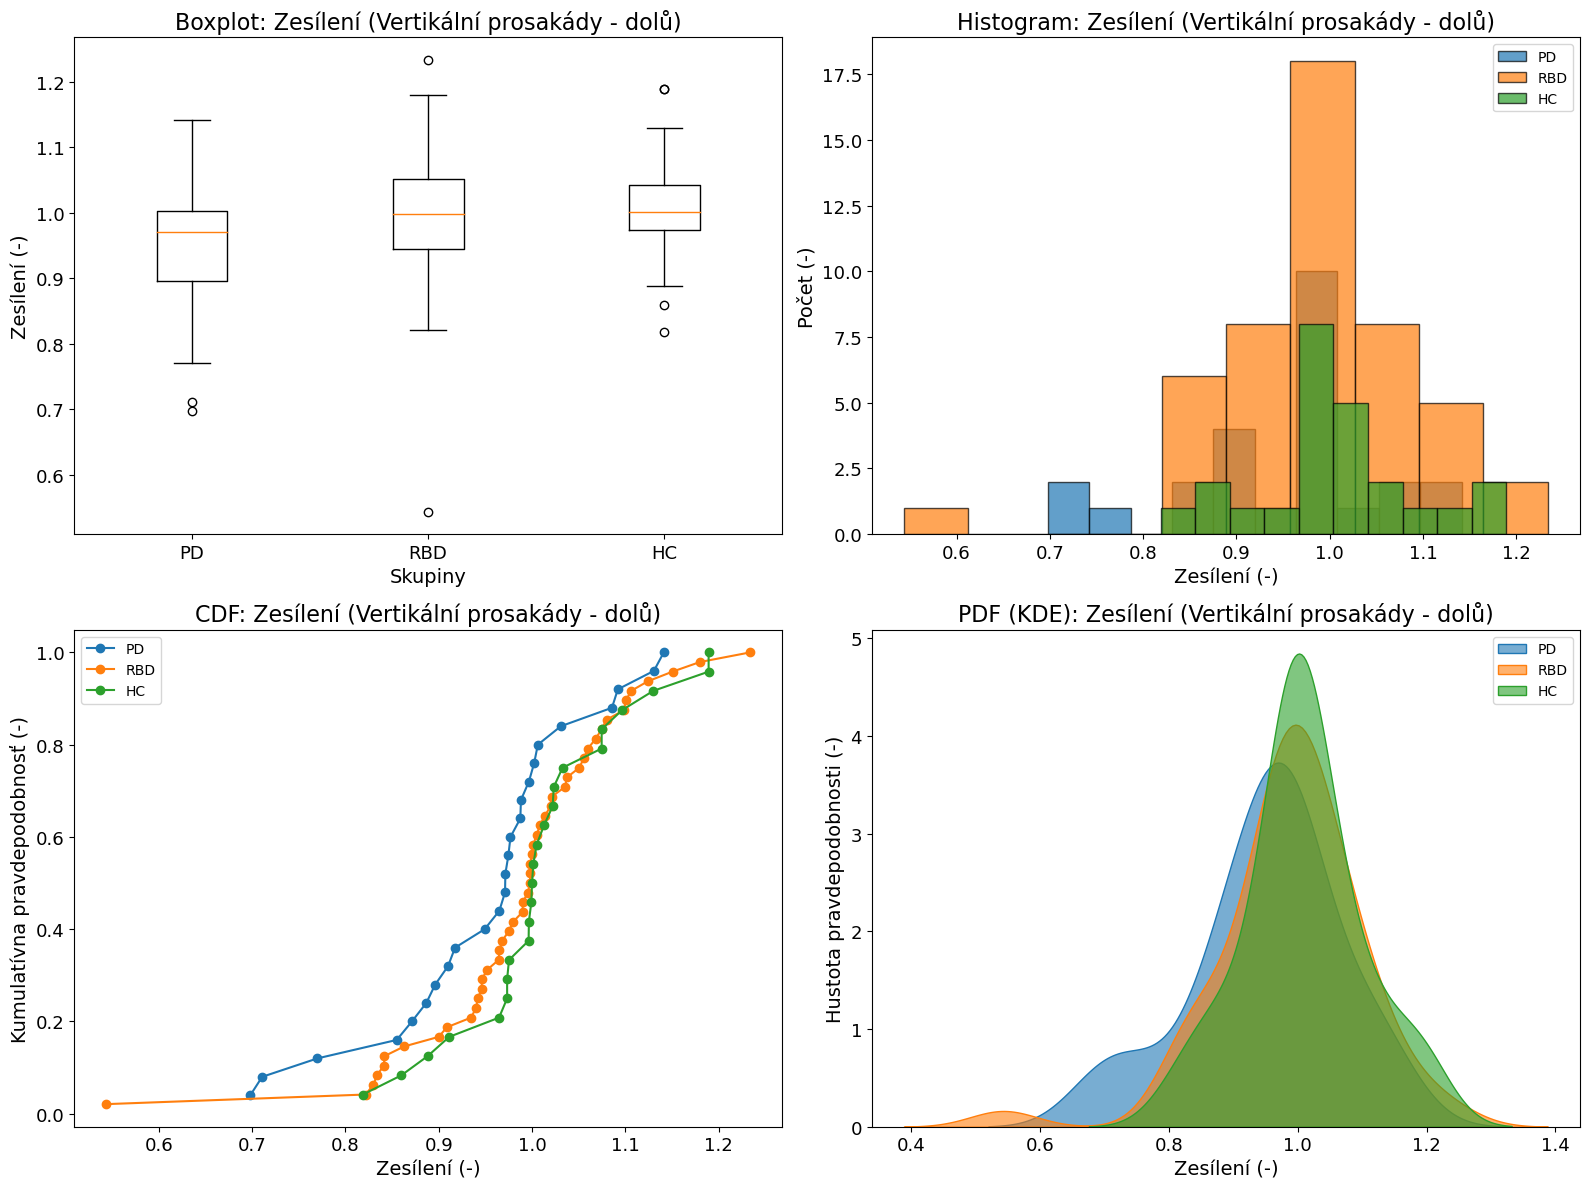


==== Testy pre parameter: Reakční čas ====
Shapiro-Wilk test normálnosti:
  PD: p=2.7165e-02
  RBD: p=1.7981e-05
  HC: p=9.0646e-01
Levene test homogenity variancií: Stat=2.3112, p=1.0475e-01
Kruskal-Wallis: Stat=6.0795, p=4.7848e-02

Post-hoc test (Dunnov test):
           HC        PD       RBD
HC   1.000000  0.410413  0.041118
PD   0.410413  1.000000  1.000000
RBD  0.041118  1.000000  1.000000
Cohenovo d (RBD vs HC): 0.6399
Cohenovo d (HC vs RBD): -0.6399

==== Testy pre parameter: Průměrná rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=3.7628e-01
  RBD: p=8.3637e-01
  HC: p=3.9332e-01
Levene test homogenity variancií: Stat=6.3319, p=2.6315e-03
Kruskal-Wallis: Stat=3.2880, p=1.9321e-01

==== Testy pre parameter: Maximální rychlost ====
Shapiro-Wilk test normálnosti:
  PD: p=7.3118e-01
  RBD: p=1.2230e-01
  HC: p=8.7685e-01
Levene test homogenity variancií: Stat=1.3790, p=2.5688e-01
ANOVA: Stat=3.1249, p=4.8540e-02

Post-hoc test (Tukey HSD):
  Multiple Comparison of Means - T

In [14]:
analyze_data("data.csv", [0, 20, 21, 22, 23], "Vertikální prosakády - dolů")

#################################################
#                PCA & MANOVA                   #
#################################################

In [19]:

def preprocess_data(file_path, rows_range, columns_indices, group_ranges):
    """
    Načíta dáta, vyberie relevantné stĺpce a riadky, rozdelí ich na skupiny a odstráni chýbajúce hodnoty.
    """
    data = pd.read_csv(file_path).iloc[rows_range, columns_indices]
    # Pridanie pracovných názvov pre stĺpce
    column_names = ['Skupina'] + [f'Feature_{i}' for i in range(1, len(columns_indices))]
    data.columns = column_names
    
    data['Skupina'] = None
    for group, (start, end) in group_ranges.items():
        data.loc[start:end, 'Skupina'] = group
    
    return data.dropna()


def perform_pca(data, feature_columns, n_components=2):
    """
    Škáluje dáta a vykonáva PCA redukciu.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[feature_columns])
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)
    
    for i in range(n_components):
        data[f'PCA{i+1}'] = pca_data[:, i]
    return data


def perform_manova(data, response_vars, group_var):
    """
    Vykoná MANOVA test a vráti výsledky.
    """
    formula = " + ".join(response_vars) + f" ~ {group_var}"
    manova_model = MANOVA.from_formula(formula, data=data)
    return manova_model.mv_test()


def tukey_posthoc(data, response_vars, group_var, save_plots=False, titles=None):
    """
    Vykoná post-hoc analýzu, vypočíta Cohenovo d a vizualizuje výsledky s možnosťou nastaviť nadpisy grafov.
    """
    if titles is None:
        titles = {col: f"Tukey post-hoc pre {col}" for col in response_vars}
    
    for col in response_vars:
        print(f"\nPost-hoc analýza pre komponentu: {col}")
        tukey = pairwise_tukeyhsd(endog=data[col], groups=data[group_var], alpha=0.05)
        print(tukey)
        
        # Výpočet Cohenovo d pre štatisticky významné rozdiely
        print(f"\nCohenovo d pre štatisticky významné rozdiely ({col}):")
        tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
        for _, row in tukey_results.iterrows():
            group1, group2, reject = row['group1'], row['group2'], row['reject']
            if reject:  # Štatisticky významný rozdiel
                group1_data = data[data[group_var] == group1][col]
                group2_data = data[data[group_var] == group2][col]
                d = compute_cohen_d(group1_data, group2_data)
                print(f"  {group1} vs {group2}: Cohenovo d = {d:.4f}")
        
        if save_plots:
            plt.figure(figsize=(8, 5))
            plt.bar(
                tukey_results['group1'] + " vs " + tukey_results['group2'],
                tukey_results['reject'],
                color='skyblue'
            )
            plt.title(titles.get(col, f"Tukey post-hoc pre {col}"))
            plt.ylabel("Významnosť (1 = rozdiel, 0 = žiadny rozdiel)")
            plt.xticks(rotation=45)
            plt.tight_layout()

            file_name = f"{col}_tukey_plot.png"
            plt.savefig(os.path.join(os.getcwd(), file_name))
            print(f"Graf uložený ako {file_name}")
            plt.show()



def analyze_dataset(file_path, rows_range, columns_indices, group_ranges, group_var='Skupina', titles=None):
    """
    Kompletná analýza datasetu: predspracovanie, PCA, MANOVA a post-hoc analýza s možnosťou nastaviť nadpisy grafov.
    """
    data = preprocess_data(file_path, rows_range, columns_indices, group_ranges)
    feature_columns = [col for col in data.columns if col != group_var]
    
    data = perform_pca(data, feature_columns)
    
    response_vars = [f'PCA{i+1}' for i in range(2)]
    print("\n==== MANOVA na PCA komponentoch ====")
    manova_results = perform_manova(data, response_vars, group_var)
    print(manova_results)
    
    print("\n==== Post-hoc analýza ====")
    tukey_posthoc(data, response_vars, group_var, save_plots=True, titles=titles)


# Horizontální antisakády a prosakády (doprava a doleva)


==== MANOVA na PCA komponentoch ====
                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8976 2.0000 93.0000  5.3025 0.0066
          Pillai's trace 0.1024 2.0000 93.0000  5.3025 0.0066
  Hotelling-Lawley trace 0.1140 2.0000 93.0000  5.3025 0.0066
     Roy's greatest root 0.1140 2.0000 93.0000  5.3025 0.0066
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Skupina         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8158 4.0000 186.0000  4.9831 0.0008
         Pillai's trace 0.1921 4.0000 188.0000  4.

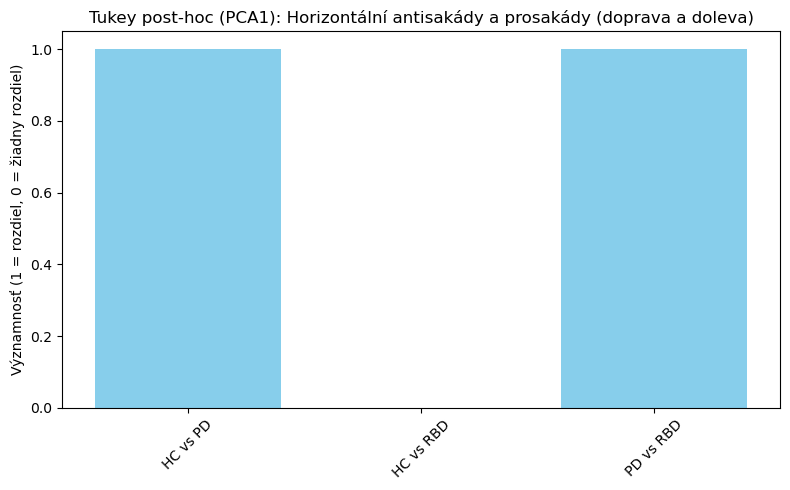


Post-hoc analýza pre komponentu: PCA2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     PD   0.9919 0.0313  0.0725 1.9114   True
    HC    RBD   1.1858  0.002  0.3814 1.9901   True
    PD    RBD   0.1938 0.8303 -0.5998 0.9874  False
---------------------------------------------------

Cohenovo d pre štatisticky významné rozdiely (PCA2):
  HC vs PD: Cohenovo d = -0.8089
  HC vs RBD: Cohenovo d = -0.9736
Graf uložený ako PCA2_tukey_plot.png


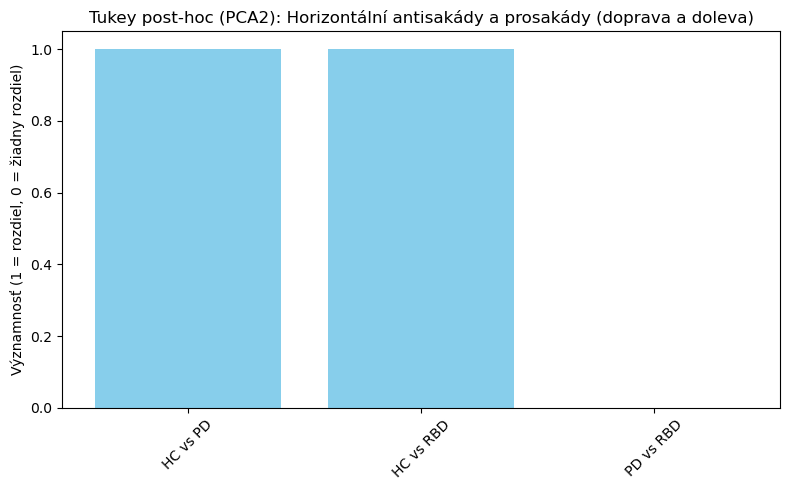

In [20]:
analyze_dataset(
    file_path="data.csv",
    rows_range=slice(4, 102),
    columns_indices=[0, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15],
    group_ranges={'PD': (4, 28), 'RBD': (29, 76), 'HC': (77, 101)},
    titles={
        'PCA1': 'Tukey post-hoc (PCA1): Horizontální antisakády a prosakády (doprava a doleva)',
        'PCA2': 'Tukey post-hoc (PCA2): Horizontální antisakády a prosakády (doprava a doleva)'
    }
)

# Vertikální antisakády a prosakády (nahoru a dolů)


==== MANOVA na PCA komponentoch ====
                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9814 2.0000 93.0000  0.8805 0.4180
          Pillai's trace 0.0186 2.0000 93.0000  0.8805 0.4180
  Hotelling-Lawley trace 0.0189 2.0000 93.0000  0.8805 0.4180
     Roy's greatest root 0.0189 2.0000 93.0000  0.8805 0.4180
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Skupina         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9408 4.0000 186.0000  1.4413 0.2220
         Pillai's trace 0.0601 4.0000 188.0000  1.

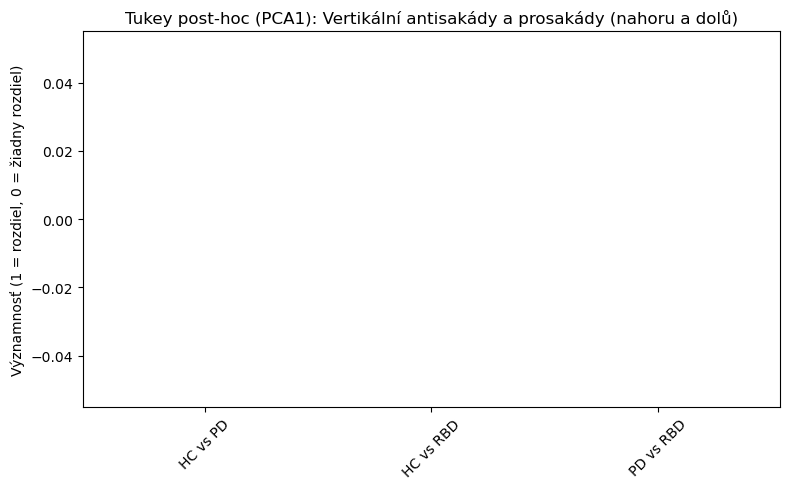


Post-hoc analýza pre komponentu: PCA2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     PD  -0.2203 0.8527 -1.1953 0.7546  False
    HC    RBD   0.3678 0.5617 -0.4851 1.2207  False
    PD    RBD   0.5882 0.2242 -0.2533 1.4296  False
---------------------------------------------------

Cohenovo d pre štatisticky významné rozdiely (PCA2):
Graf uložený ako PCA2_tukey_plot.png


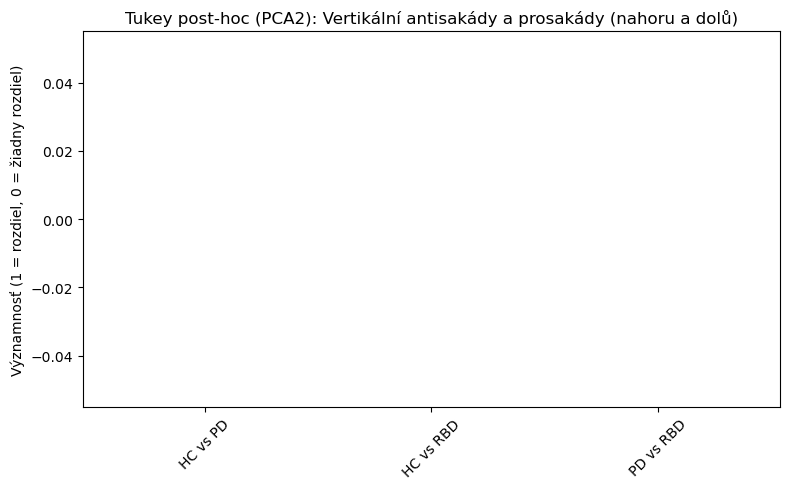

In [21]:
analyze_dataset(
    file_path="data.csv",
    rows_range=slice(4, 102),
    columns_indices=[0, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23],
    group_ranges={'PD': (4, 28), 'RBD': (29, 76), 'HC': (77, 101)},
    titles={
        'PCA1': 'Tukey post-hoc (PCA1): Vertikální antisakády a prosakády (nahoru a dolů)',
        'PCA2': 'Tukey post-hoc (PCA2): Vertikální antisakády a prosakády (nahoru a dolů)'
    }
)

# Věk a Reakční časy


==== MANOVA na PCA komponentoch ====
                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9639 2.0000 93.0000  1.7410 0.1810
          Pillai's trace 0.0361 2.0000 93.0000  1.7410 0.1810
  Hotelling-Lawley trace 0.0374 2.0000 93.0000  1.7410 0.1810
     Roy's greatest root 0.0374 2.0000 93.0000  1.7410 0.1810
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Skupina         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8450 4.0000 186.0000  4.0842 0.0034
         Pillai's trace 0.1599 4.0000 188.0000  4.

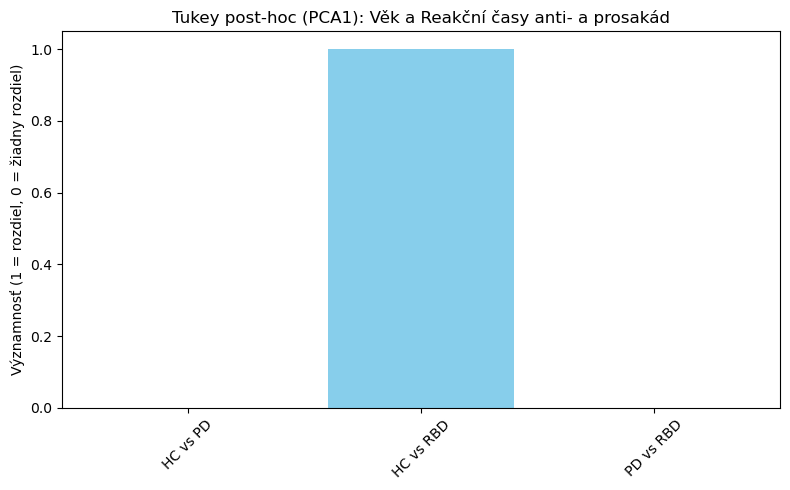


Post-hoc analýza pre komponentu: PCA2
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    HC     PD   0.5368  0.099 -0.0771  1.1506  False
    HC    RBD  -0.1535 0.7752 -0.6906  0.3835  False
    PD    RBD  -0.6903 0.0071 -1.2201 -0.1605   True
----------------------------------------------------

Cohenovo d pre štatisticky významné rozdiely (PCA2):
  PD vs RBD: Cohenovo d = 0.7523
Graf uložený ako PCA2_tukey_plot.png


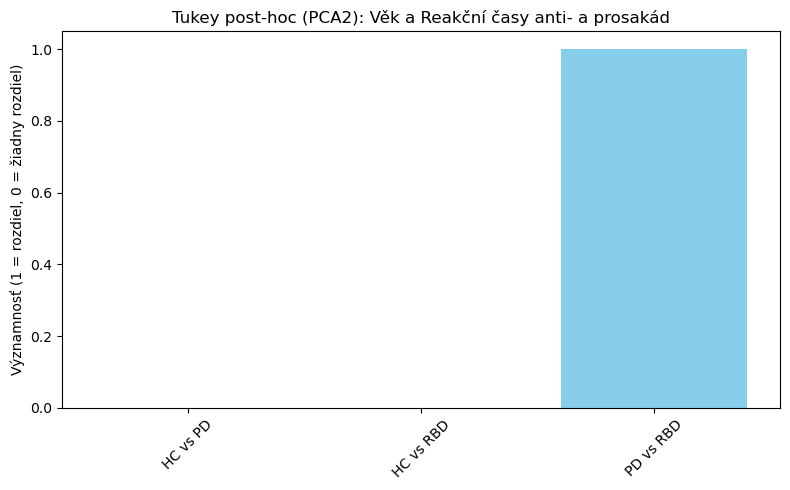

In [22]:

analyze_dataset(
    file_path="data.csv",
    rows_range=slice(4, 102),
    columns_indices=[0, 1, 4, 6, 8, 12, 16, 20],
    group_ranges={'PD': (4, 28), 'RBD': (29, 76), 'HC': (77, 101)},
    titles={
        'PCA1': 'Tukey post-hoc (PCA1): Věk a Reakční časy anti- a prosakád',
        'PCA2': 'Tukey post-hoc (PCA2): Věk a Reakční časy anti- a prosakád'
    }
)